# Comprehensive Analysis and Model Training

This notebook performs:
1. Data merging (load + weather)
2. Seasonal analysis
3. Best model finding for 3 tasks:
   - Hourly load forecasting
   - Peak hour prediction
   - Peak days prediction
4. Saves trained best models for production use

## 1. Setup and Configuration

In [3]:
# Install required packages
!pip install xgboost lightgbm catboost holidays --break-system-packages

In [4]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import warnings
import holidays
import pickle
from datetime import datetime, timedelta
import pytz

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import confusion_matrix, classification_report
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from catboost import CatBoostRegressor
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("Libraries imported successfully")

Libraries imported successfully


In [5]:
# ============================================================================
# CONFIGURATION
# ============================================================================

# Directory paths (relative to src/)
LOAD_DIR = "../data/raw/hrl_load_metered_2016-2025"
WEATHER_DIR = "../data/raw/weather"
PROCESSED_DIR = "../data/processed"
FIGURES_DIR = "../figures"
OUTPUT_DIR = "../output"

# Create directories if they don't exist
os.makedirs(PROCESSED_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Target 29 load areas
KEEP_AREAS = [
    "AECO", "AEPAPT", "AEPIMP", "AEPKPT", "AEPOPT", "AP", "BC", "CE", "DAY", "DEOK",
    "DOM", "DPLCO", "DUQ", "EASTON", "EKPC", "JC", "ME", "OE", "OVEC", "PAPWR",
    "PE", "PEPCO", "PLCO", "PN", "PS", "RECO", "SMECO", "UGI", "VMEU"
]

# Best Model Finding dates (2024 test)
TRAIN_START = '2016-01-01 00:00:00'
TRAIN_END = '2024-10-30 23:00:00'
TEST_START = '2024-11-20 00:00:00'
TEST_END = '2024-11-29 23:00:00'

FINAL_TRAIN_START = '2016-01-01 00:00:00'
FINAL_TRAIN_END = '2025-10-30 23:00:00'

# Rolling window for peak days
WINDOW_SIZE = 10  # days
NUM_PEAK_DAYS = 2

print("Configuration loaded")
print(f"\nBest Model Finding Period:")
print(f"  Train: {TRAIN_START} to {TRAIN_END}")
print(f"  Test:  {TEST_START} to {TEST_END}")

Configuration loaded

Best Model Finding Period:
  Train: 2016-01-01 00:00:00 to 2024-10-30 23:00:00
  Test:  2024-11-20 00:00:00 to 2024-11-29 23:00:00


## 2. Data Merging

In [7]:
# Helper functions
def n_distinct_na_omit(series):
    """Count unique non-null values in a series"""
    return series.dropna().nunique()

def add_seconds(time_str):
    """Add seconds to time string if not present"""
    import re
    if re.search(r':\d{2}$', time_str):
        return time_str + ":00"
    return time_str

def parse_et(series):
    """Parse datetime with Eastern Time timezone handling"""
    if pd.api.types.is_datetime64_any_dtype(series):
        result = pd.to_datetime(series)
        if result.dt.tz is None:
            return result.dt.tz_localize('America/New_York', ambiguous='NaT', nonexistent='NaT')
        return result
    result = pd.to_datetime(series, format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
    mask = result.isna()
    if mask.any():
        result[mask] = pd.to_datetime(series[mask], errors='coerce')
    return result.dt.tz_localize('America/New_York', ambiguous='NaT', nonexistent='NaT')

print("Helper functions defined")

Helper functions defined


In [8]:
print("=" * 70)
print("STEP 1: LOADING AND MERGING DATA")
print("=" * 70)

# Load all yearly load files
load_files = sorted(glob.glob(os.path.join(LOAD_DIR, "hrl_load_metered_*.csv")))

if len(load_files) == 0:
    raise ValueError(f"No load files found in {LOAD_DIR}")

print(f"\nFound {len(load_files)} load files")

datasets = {}
for f in load_files:
    year = os.path.basename(f).split('_')[-1].replace('.csv', '')
    df = pd.read_csv(f)
    df['year'] = int(year)
    datasets[year] = df
    print(f"  Loaded {year}: {len(df):,} rows")

STEP 1: LOADING AND MERGING DATA

Found 10 load files
  Loaded 2016: 245,952 rows
  Loaded 2017: 250,417 rows
  Loaded 2018: 254,784 rows
  Loaded 2019: 262,800 rows
  Loaded 2020: 263,520 rows
  Loaded 2021: 262,800 rows
  Loaded 2022: 262,800 rows
  Loaded 2023: 262,800 rows
  Loaded 2024: 263,520 rows
  Loaded 2025: 218,130 rows


In [9]:
# Combine all years and filter to 29 areas
load_df = pd.concat(datasets.values(), ignore_index=True)
load_df = load_df[load_df['load_area'].isin(KEEP_AREAS)].copy()

print(f"\nCombined load data: {len(load_df):,} rows")
print(f"Unique load areas: {load_df['load_area'].nunique()}")

# Parse datetime
# Parse datetime and snap to hour
load_df['dt_ept'] = pd.to_datetime(
    load_df['datetime_beginning_ept'],
    format='%m/%d/%Y %I:%M:%S %p'
)

# Localize to ET timezone
load_df['dt_ept'] = load_df['dt_ept'].dt.tz_localize('America/New_York', ambiguous='NaT', nonexistent='NaT')

# Snap to hour (floor to beginning of hour)
load_df['dt_ept'] = load_df['dt_ept'].dt.floor('h')
print(f"After datetime parsing: {len(load_df):,} rows")


Combined load data: 2,452,556 rows
Unique load areas: 29
After datetime parsing: 2,452,556 rows


In [10]:
# Load weather data
weather_files = sorted(glob.glob(os.path.join(WEATHER_DIR, "*.csv")))

if len(weather_files) == 0:
    raise ValueError(f"No weather files found in {WEATHER_DIR}")

print(f"\nFound {len(weather_files)} weather files")

weather_dfs = []
for f in weather_files:
    df = pd.read_csv(f)
    year = os.path.basename(f).split('_')[-1].replace('.csv', '')
    weather_dfs.append(df)
    print(f"Loaded {year}: {len(df):,} rows")

weather_df = pd.concat(weather_dfs, ignore_index=True)

print(f"\nCombined weather data: {len(weather_df):,} rows")
print(f"Load areas: {weather_df['load_area'].nunique()}")


Found 10 weather files
Loaded 2016: 254,736 rows
Loaded 2017: 254,040 rows
Loaded 2018: 254,040 rows
Loaded 2019: 254,040 rows
Loaded 2020: 254,736 rows
Loaded 2021: 254,040 rows
Loaded 2022: 254,040 rows
Loaded 2023: 254,040 rows
Loaded 2024: 254,736 rows
Loaded 2025: 223,416 rows

Combined weather data: 2,511,864 rows
Load areas: 29


In [11]:
# Parse ET datetime
weather_df['wx_ept'] = pd.to_datetime(
    weather_df['datetime_beginning_ept'],
    format='%Y-%m-%d %H:%M:%S'
)

# Localize to ET timezone
weather_df['wx_ept'] = weather_df['wx_ept'].dt.tz_localize('America/New_York', ambiguous='NaT', nonexistent='NaT')

# Snap to hour
weather_df['wx_ept'] = weather_df['wx_ept'].dt.floor('h')

# Create ordering column for UTC time (for stable deduplication)
weather_df['order_utc'] = pd.to_datetime(
    weather_df['datetime_beginning_utc'],
    format='%Y-%m-%dT%H:%M:%S',
    utc=True
)

# Sort by load_area, wx_ept, and order_utc
weather_df = weather_df.sort_values(['load_area', 'wx_ept', 'order_utc'])

# Remove duplicates (keep first occurrence)
weather_dedup = weather_df.drop_duplicates(subset=['load_area', 'wx_ept'], keep='first').copy()

# Drop the ordering column
weather_dedup = weather_dedup.drop(columns=['order_utc'])

print(f"Weather data before deduplication: {len(weather_df):,} rows")
print(f"Weather data after deduplication: {len(weather_dedup):,} rows")
print(f"Duplicates removed: {len(weather_df) - len(weather_dedup):,}")

Weather data before deduplication: 2,511,864 rows
Weather data after deduplication: 2,511,313 rows
Duplicates removed: 551


In [12]:
# Select weather columns to keep
keep_wx = ['load_area', 'wx_ept', 'temp', 'humidity', 'dew_point', 'precip', 'wind']

# Perform left merge
merged = load_df.merge(
    weather_dedup[keep_wx],
    left_on=['load_area', 'dt_ept'],
    right_on=['load_area', 'wx_ept'],
    how='left'
)

# Drop the helper datetime columns used for merging
merged = merged.drop(columns=['dt_ept', 'wx_ept','year'])

print(f"\nMerged data: {len(merged):,} rows")
print(f"Weather coverage: {(~merged['temp'].isna()).sum() / len(merged) * 100:.2f}%")

# Save merged data
output_file = os.path.join(PROCESSED_DIR, "merged_load_weather.csv")
merged.to_csv(output_file, index=False)
print(f"\nMerged data saved to: {output_file}")
print(f"File size: {os.path.getsize(output_file) / (1024**2):.2f} MB")


Merged data: 2,452,556 rows
Weather coverage: 100.00%

Merged data saved to: ../data/processed/merged_load_weather.csv
File size: 223.82 MB


## 3. Seasonal Analysis

In [14]:
# Parse datetime
merged['datetime_beginning_ept'] = parse_et(merged['datetime_beginning_ept'])

# Check for NaT values
nat_count = merged['datetime_beginning_ept'].isna().sum()
print(f"Found {nat_count} rows with invalid datetime")

if nat_count > 0:
    # Show sample of problematic rows
    print("\nSample of rows with NaT:")
    print(merged[merged['datetime_beginning_ept'].isna()][['datetime_beginning_ept', 'load_area']].head())
    
    # Drop rows with NaT
    merged = merged.dropna(subset=['datetime_beginning_ept'])
    print(f"\nDropped {nat_count} rows with invalid datetime")
    print(f"Remaining rows: {len(merged):,}")

print("DateTime parsed successfully!")
print(f"Date range: {merged['datetime_beginning_ept'].min()} to {merged['datetime_beginning_ept'].max()}")

Found 512 rows with invalid datetime

Sample of rows with NaT:
       datetime_beginning_ept load_area
193440                    NaT        BC
193441                    NaT     DPLCO
193442                    NaT    EASTON
193443                    NaT        JC
193444                    NaT        ME

Dropped 512 rows with invalid datetime
Remaining rows: 2,452,044
DateTime parsed successfully!
Date range: 2016-01-01 00:00:00-05:00 to 2025-10-30 23:00:00-04:00


In [15]:
print("\n" + "=" * 70)
print("STEP 2: SEASONAL ANALYSIS")
print("=" * 70)

# Prepare data for seasonal analysis
df_season = merged.copy()
df_season['datetime'] = pd.to_datetime(df_season['datetime_beginning_ept'])
df_season['year'] = df_season['datetime'].dt.year
df_season['month'] = df_season['datetime'].dt.month
df_season['day'] = df_season['datetime'].dt.day
df_season['hour'] = df_season['datetime'].dt.hour
df_season['wday'] = df_season['datetime'].dt.dayofweek
df_season['date'] = df_season['datetime'].dt.date
df_season['dayofweek_name'] = df_season['datetime_beginning_ept'].dt.strftime('%a')

# Define seasons
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return 'Winter'

df_season['season'] = df_season['month'].apply(get_season)
# December belongs to next year's winter
df_season['season_year'] = df_season['year'].where(df_season['month'] != 12, df_season['year'] + 1)
# Day-hour index (0-167 for weekly cycle)
df_season['dayhour'] = df_season['wday'] * 24 + df_season['hour']

print(f"\nSeasonal data prepared: {len(df_season):,} rows")


STEP 2: SEASONAL ANALYSIS

Seasonal data prepared: 2,452,044 rows


In [16]:
# Monthly and yearly aggregations
monthly_tbl = df_season.groupby(['year', 'month']).agg({
    'mw': 'mean',
    'temp': 'mean',
    'humidity': 'mean',
    'wind': 'mean',
    'precip': 'mean'
}).reset_index()

yearly_tbl = df_season.groupby('year').agg({
    'mw': 'mean',
    'temp': 'mean',
    'humidity': 'mean',
    'wind': 'mean',
    'precip': 'mean'
}).reset_index()

print(f"Monthly aggregations: {len(monthly_tbl)} rows")
print(f"Yearly aggregations: {len(yearly_tbl)} rows")

Monthly aggregations: 118 rows
Yearly aggregations: 10 rows


In [17]:
def summarise_seasonal(data, group_cols):
    """Calculate seasonal means for specified grouping columns"""
    grouped = data.groupby(['season', 'season_year'] + group_cols).agg({
        'mw': 'mean',
        'temp': 'mean',
        'humidity': 'mean',
        'wind': 'mean',
        'precip': 'mean'
    }).reset_index()
    
    # Rename columns
    rename_dict = {'mw': 'Load_MW', 'temp': 'Temp_C', 'humidity': 'Humidity', 
                   'wind': 'Wind', 'precip': 'Precip'}
    grouped = grouped.rename(columns=rename_dict)
    
    # Convert to long format
    long = grouped.melt(
        id_vars=['season', 'season_year'] + group_cols,
        value_vars=['Load_MW', 'Temp_C', 'Humidity', 'Wind', 'Precip'],
        var_name='Metric',
        value_name='Value'
    )
    
    return long

# Create summaries
print("Creating seasonal summaries...")
daily_tbl = summarise_seasonal(df_season, ['wday', 'dayofweek_name'])
hourly_tbl = summarise_seasonal(df_season, ['hour'])
dayhour_tbl = summarise_seasonal(df_season, ['dayhour'])

Creating seasonal summaries...


## Monthly Trends by Year

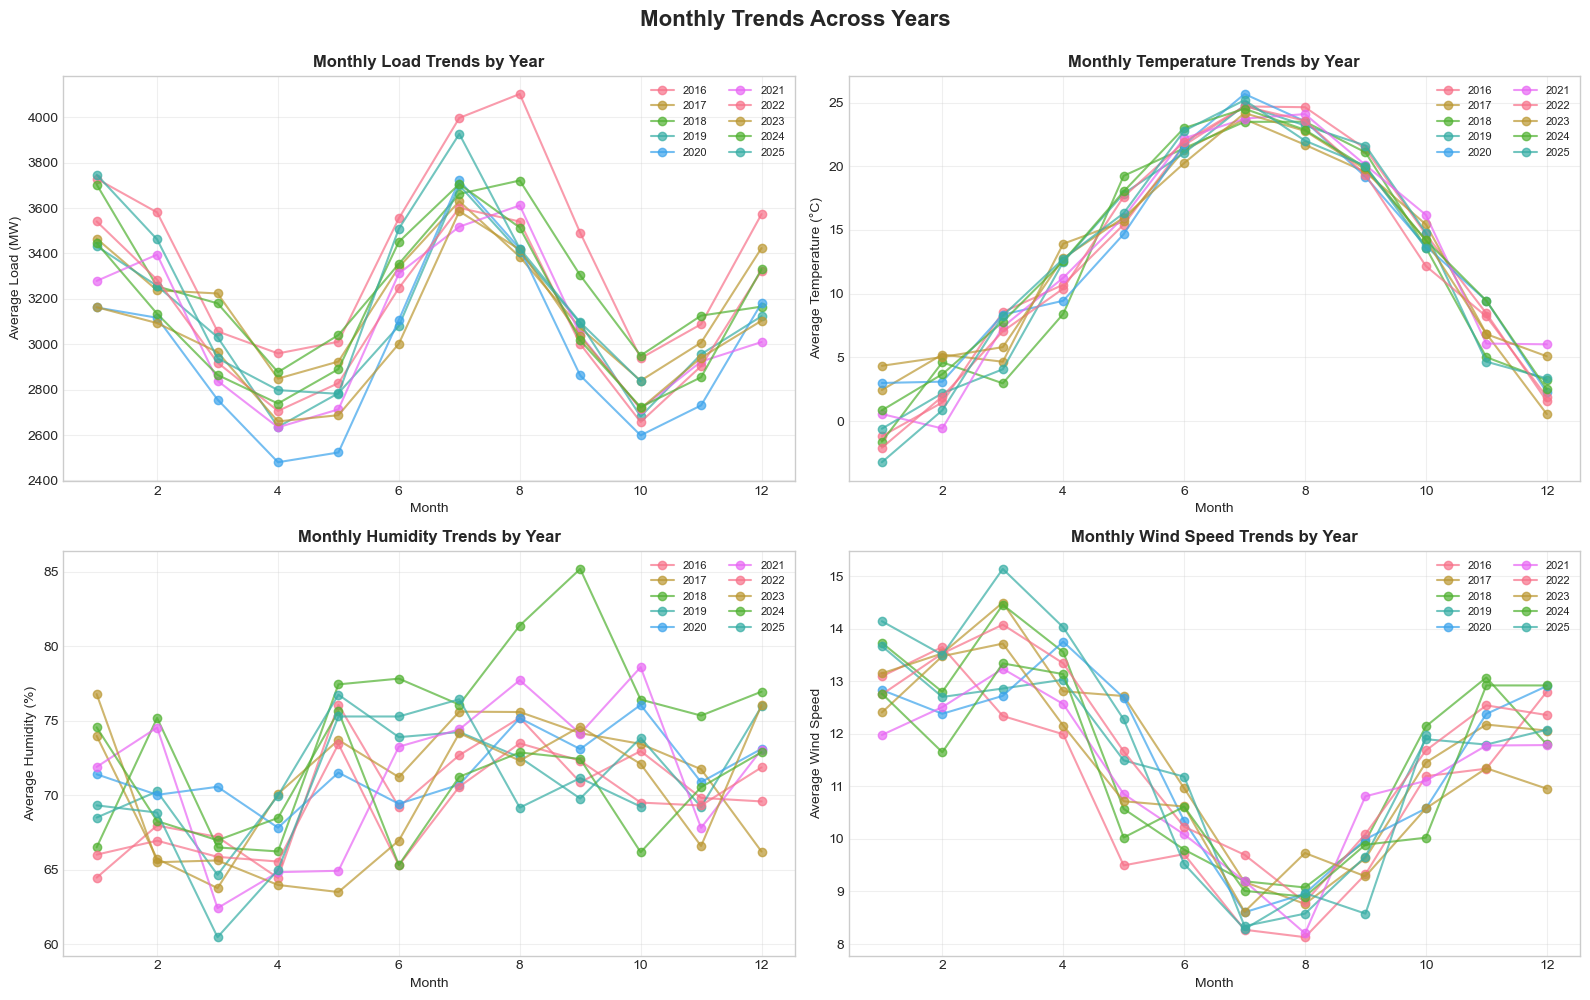


Saved: monthly_trends.png


In [19]:
# Plot 1: Monthly trends by year
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

for year in sorted(monthly_tbl['year'].unique()):
    data = monthly_tbl[monthly_tbl['year'] == year]
    axes[0, 0].plot(data['month'], data['mw'], marker='o', label=str(year), alpha=0.7)
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Average Load (MW)')
axes[0, 0].set_title('Monthly Load Trends by Year', fontweight='bold')
axes[0, 0].legend(ncol=2, fontsize=8)
axes[0, 0].grid(True, alpha=0.3)

for year in sorted(monthly_tbl['year'].unique()):
    data = monthly_tbl[monthly_tbl['year'] == year]
    axes[0, 1].plot(data['month'], data['temp'], marker='o', label=str(year), alpha=0.7)
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Average Temperature (°C)')
axes[0, 1].set_title('Monthly Temperature Trends by Year', fontweight='bold')
axes[0, 1].legend(ncol=2, fontsize=8)
axes[0, 1].grid(True, alpha=0.3)

for year in sorted(monthly_tbl['year'].unique()):
    data = monthly_tbl[monthly_tbl['year'] == year]
    axes[1, 0].plot(data['month'], data['humidity'], marker='o', label=str(year), alpha=0.7)
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Average Humidity (%)')
axes[1, 0].set_title('Monthly Humidity Trends by Year', fontweight='bold')
axes[1, 0].legend(ncol=2, fontsize=8)
axes[1, 0].grid(True, alpha=0.3)

for year in sorted(monthly_tbl['year'].unique()):
    data = monthly_tbl[monthly_tbl['year'] == year]
    axes[1, 1].plot(data['month'], data['wind'], marker='o', label=str(year), alpha=0.7)
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Average Wind Speed')
axes[1, 1].set_title('Monthly Wind Speed Trends by Year', fontweight='bold')
axes[1, 1].legend(ncol=2, fontsize=8)
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Monthly Trends Across Years', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'monthly_trends.png'), dpi=150, bbox_inches='tight')
plt.show()

print("\nSaved: monthly_trends.png")

## Yeary Trends 

In [21]:
# Plot 2: Yearly aggregate trends
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

axes[0, 0].plot(yearly_tbl['year'], yearly_tbl['mw'], marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Average Load (MW)')
axes[0, 0].set_title('Yearly Load Trend', fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(yearly_tbl['year'], yearly_tbl['temp'], marker='o', linewidth=2, markersize=8, color='coral')
axes[0, 1].set_xlabel('Year')
axes[0, 1].set_ylabel('Average Temperature (°C)')
axes[0, 1].set_title('Yearly Temperature Trend', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(yearly_tbl['year'], yearly_tbl['humidity'], marker='o', linewidth=2, markersize=8, color='lightgreen')
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Average Humidity (%)')
axes[1, 0].set_title('Yearly Humidity Trend', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(yearly_tbl['year'], yearly_tbl['wind'], marker='o', linewidth=2, markersize=8, color='purple')
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Average Wind Speed')
axes[1, 1].set_title('Yearly Wind Speed Trend', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Yearly Aggregate Trends', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'yearly_trends.png'), dpi=150, bbox_inches='tight')
plt.show()

print("Saved: yearly_trends.png")

Saved: yearly_trends.png


## Seasonal Trends by Year


Generating seasonal plots by day of week...


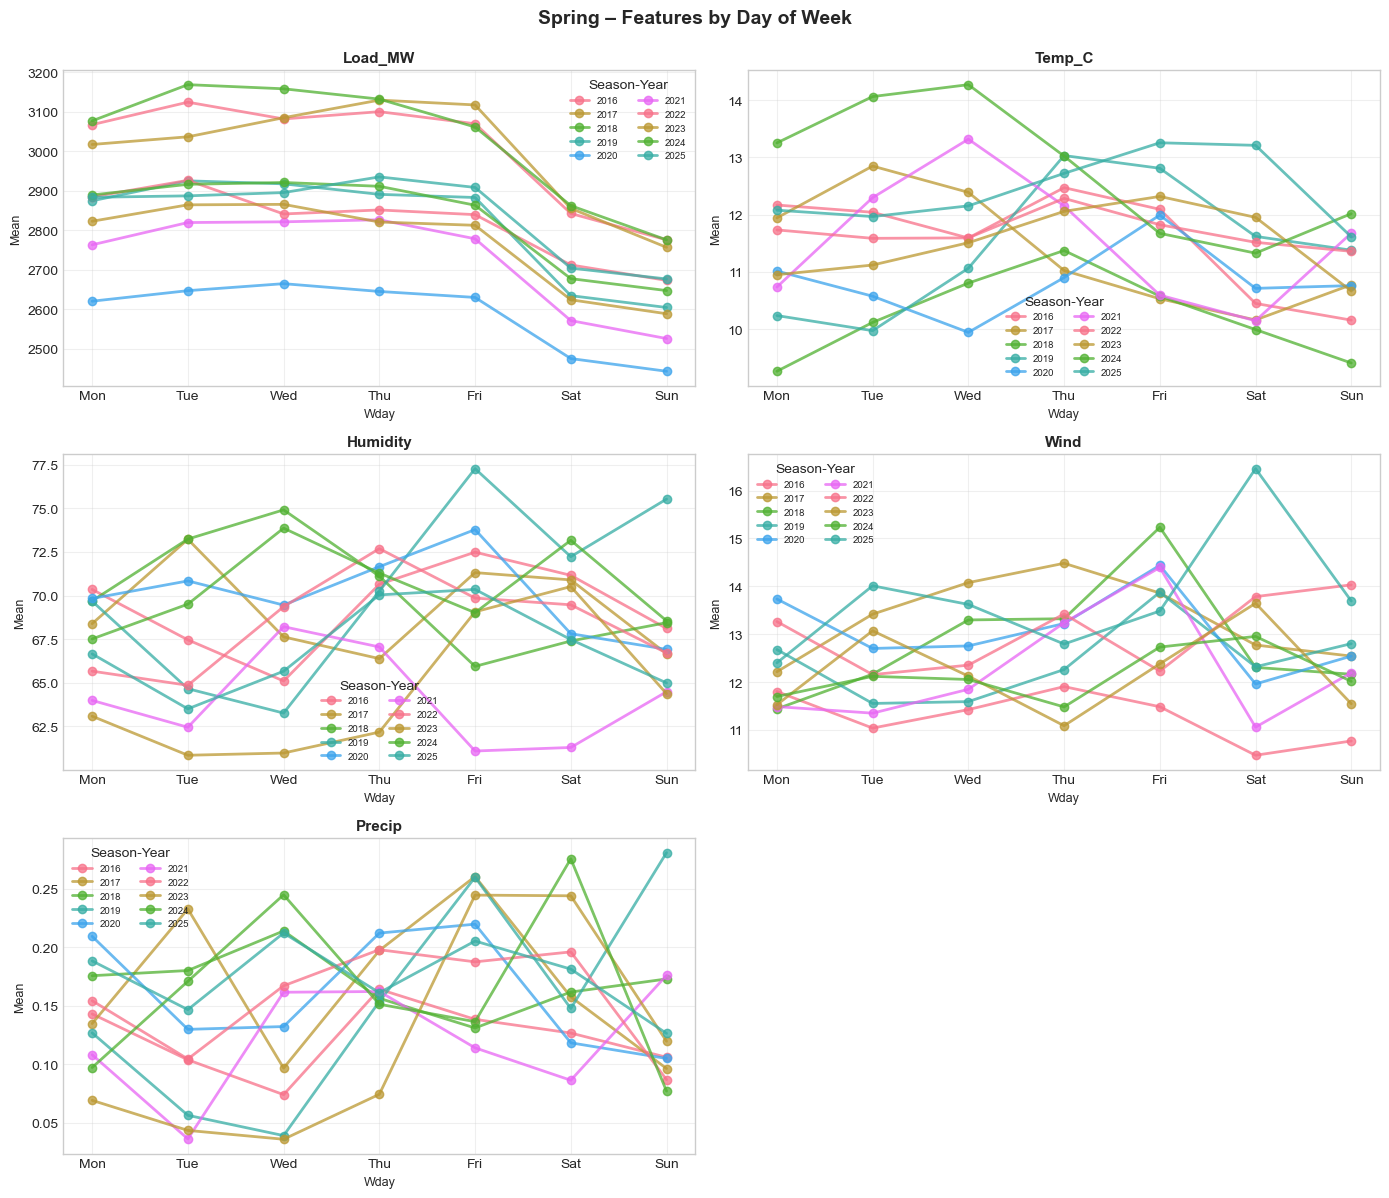

  Saved: Spring_wday.png


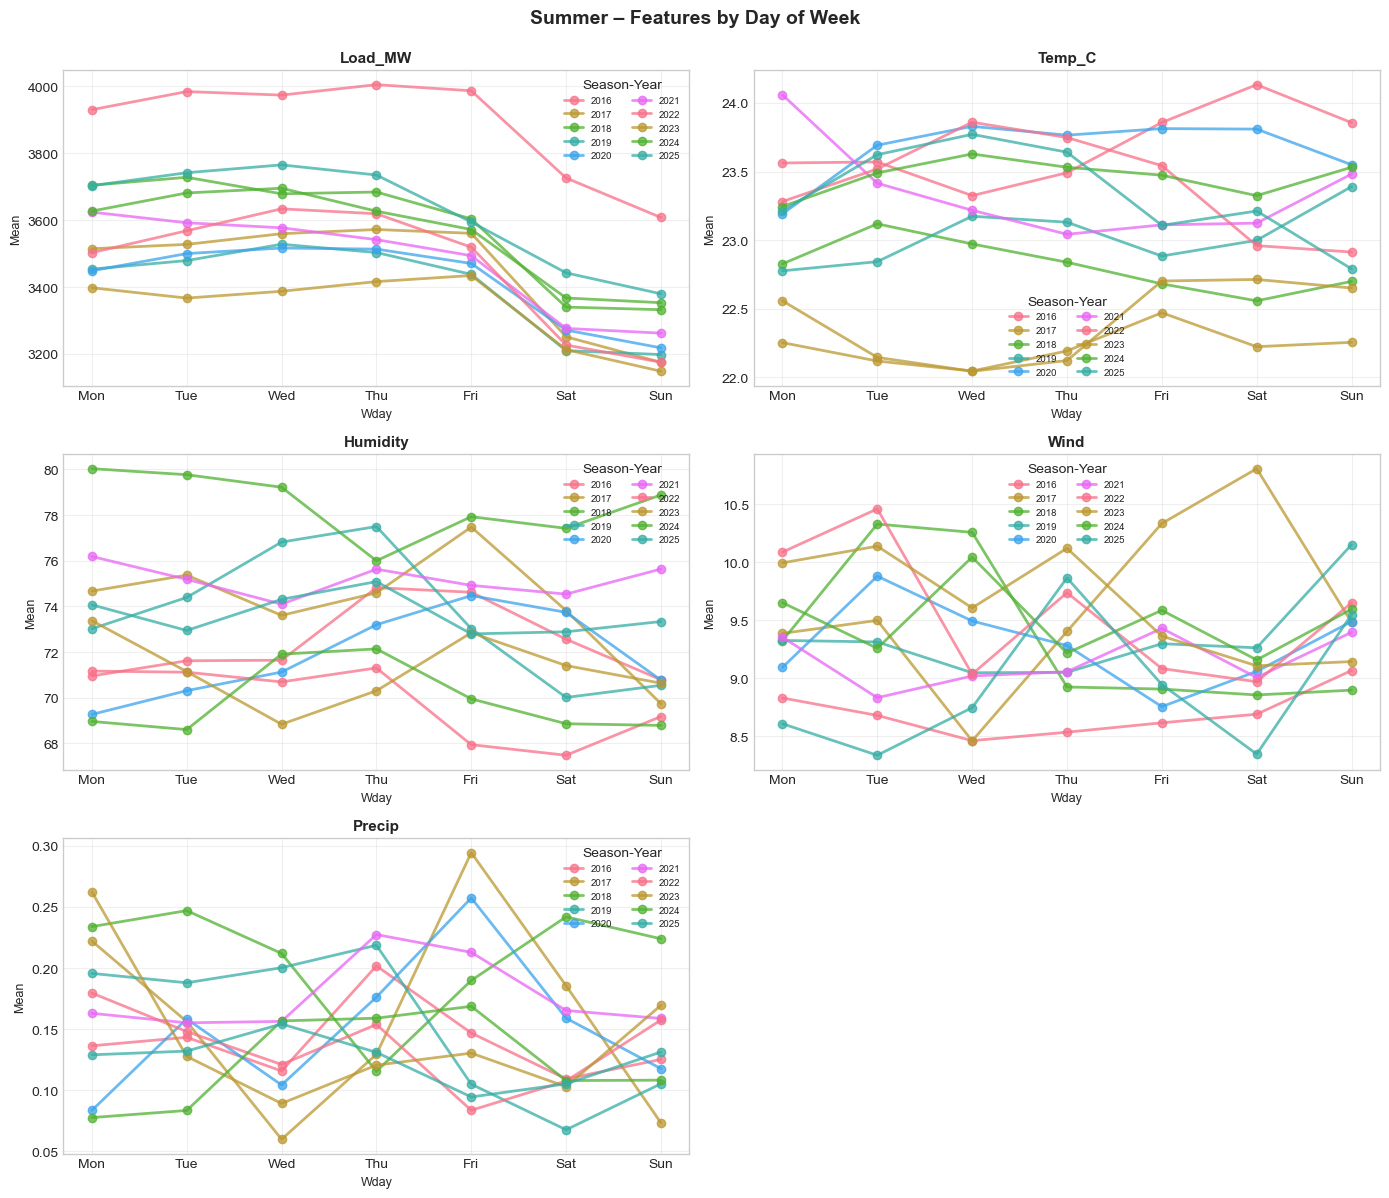

  Saved: Summer_wday.png


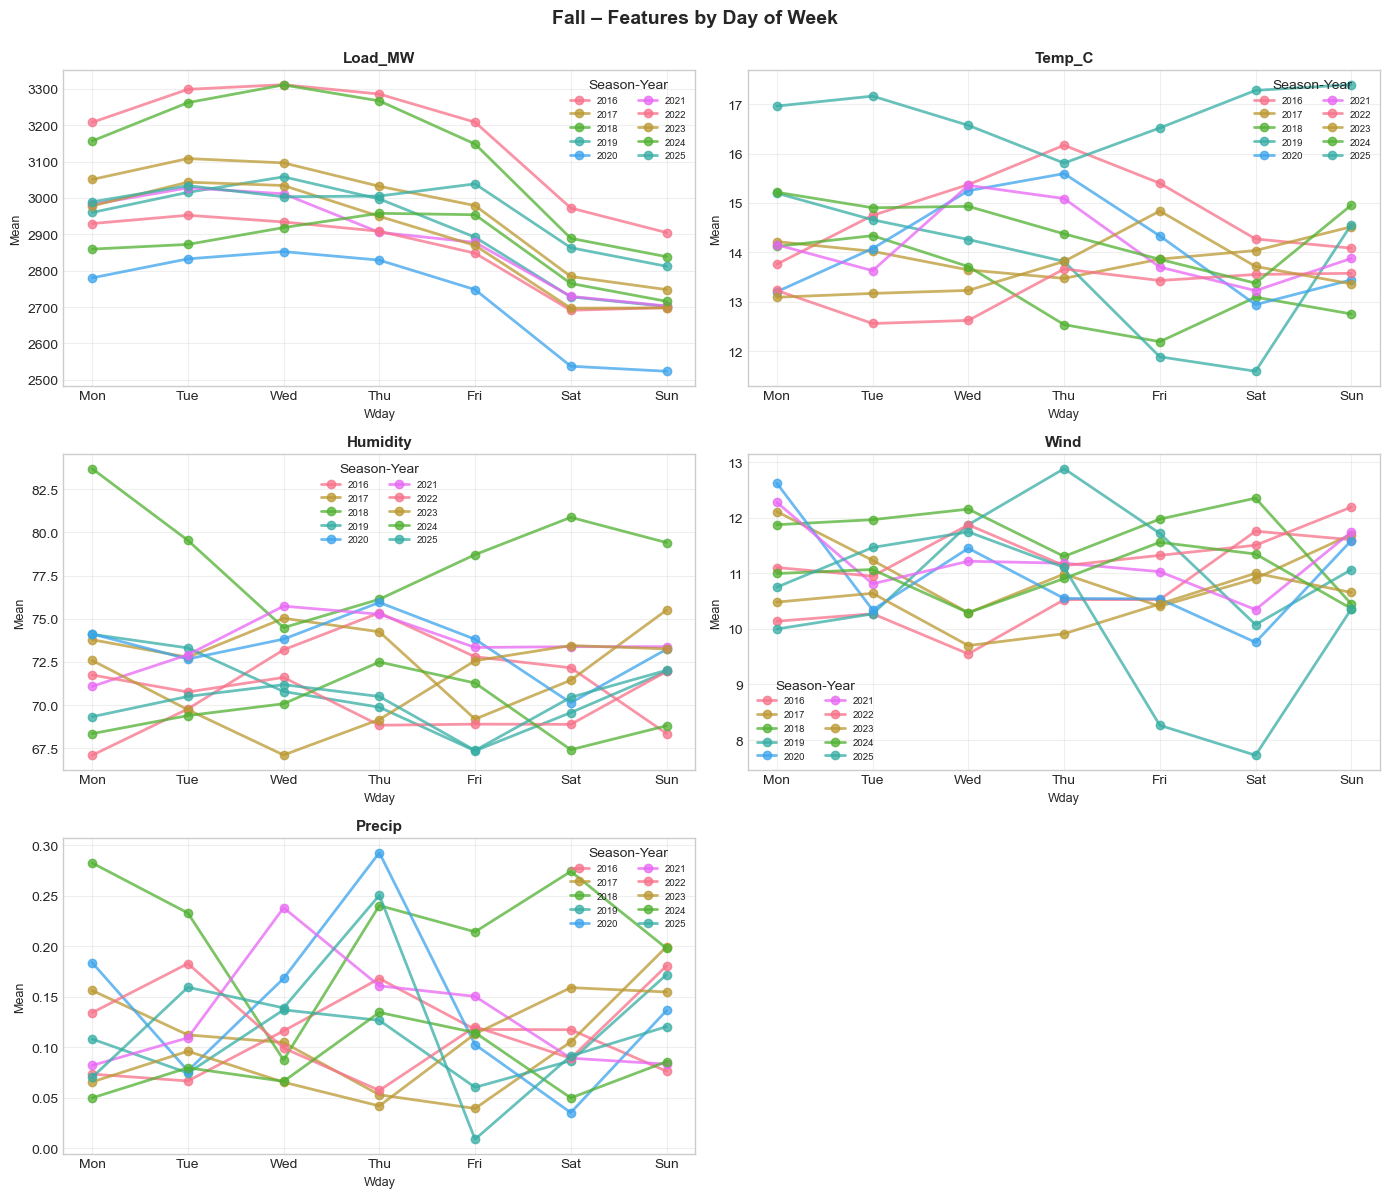

  Saved: Fall_wday.png


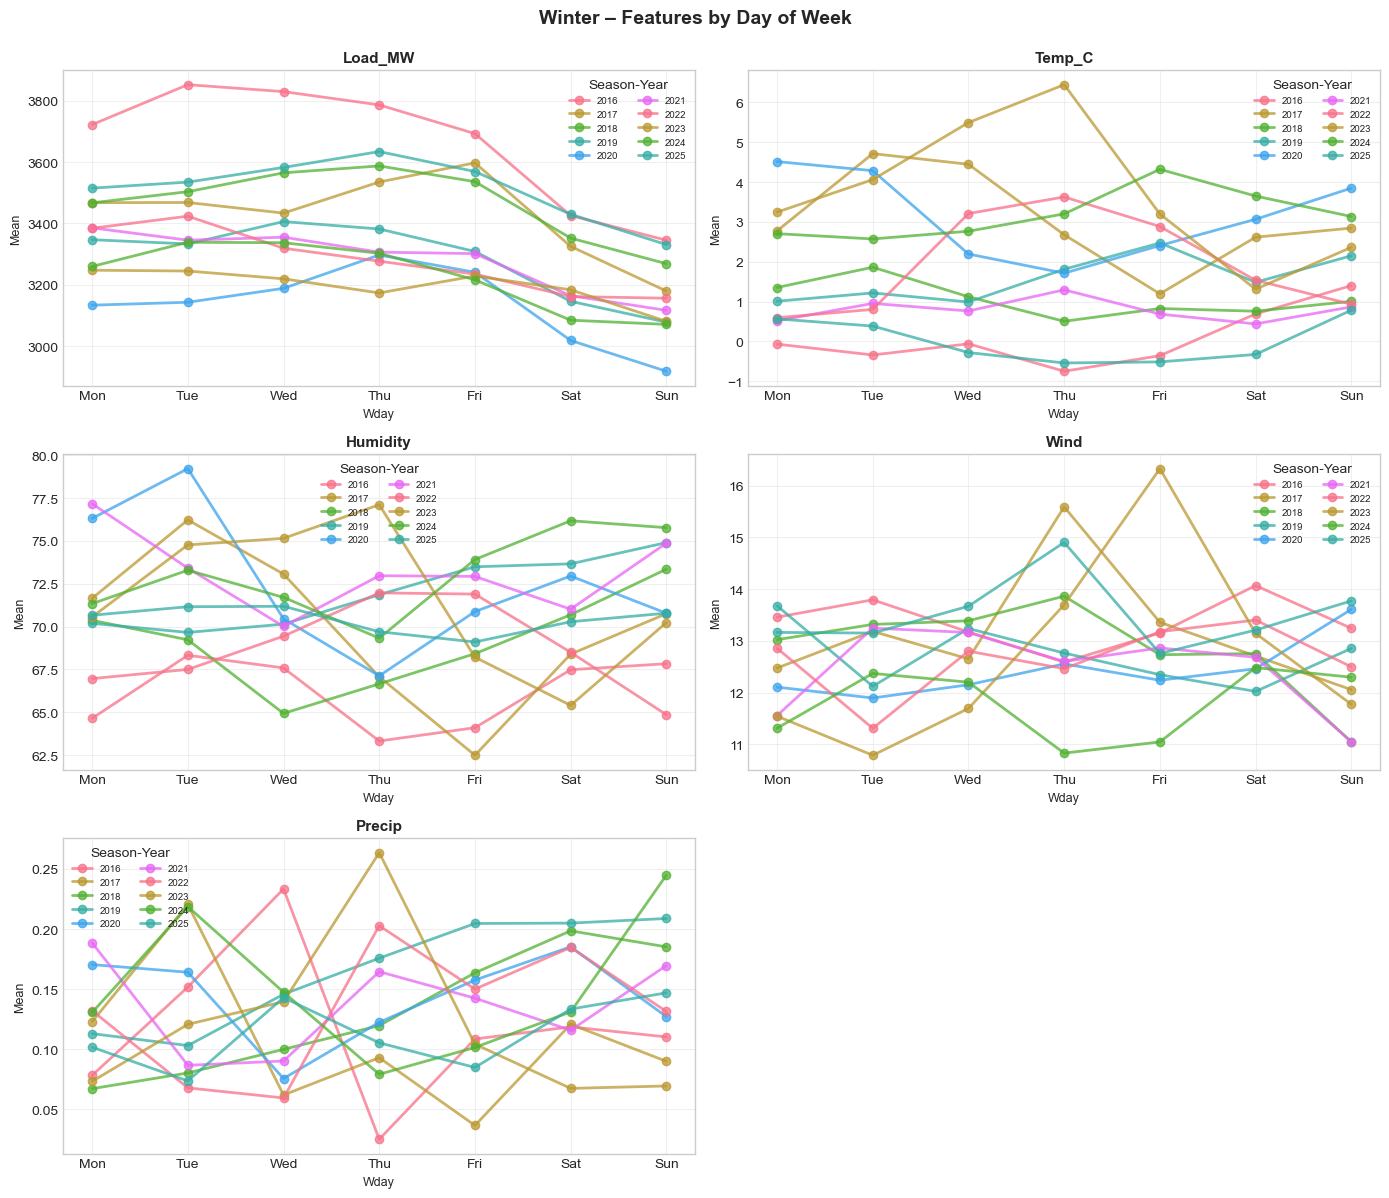

  Saved: Winter_wday.png


In [23]:
# Function to plot seasonal patterns by day of week
def plot_seasonal_by_wday(season_name, data):
    """Plot seasonal patterns by day of week"""
    season_data = data[data['season'] == season_name]
    
    # Define day order
    day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    season_data['dayofweek_name'] = pd.Categorical(season_data['dayofweek_name'], 
                                                    categories=day_order, ordered=True)
    
    fig, axes = plt.subplots(3, 2, figsize=(14, 12))
    axes = axes.flatten()
    metrics = ['Load_MW', 'Temp_C', 'Humidity', 'Wind', 'Precip']
    for idx, metric in enumerate(metrics):
        metric_data = season_data[season_data['Metric'] == metric]
        
        for year in sorted(metric_data['season_year'].unique()):
            year_data = metric_data[metric_data['season_year'] == year].sort_values('wday')
            axes[idx].plot(year_data['dayofweek_name'], year_data['Value'], 
                          marker='o', label=str(year), alpha=0.75, linewidth=2)
        
        axes[idx].set_title(f'{metric}', fontsize=11, fontweight='bold')
        axes[idx].set_xlabel('Wday', fontsize=9)
        axes[idx].set_ylabel('Mean', fontsize=9)
        axes[idx].legend(title='Season-Year', fontsize=7, ncol=2)
        axes[idx].grid(True, alpha=0.3)
    
    fig.delaxes(axes[5])
    plt.suptitle(f'{season_name} – Features by Day of Week', 
                 fontsize=14, fontweight='bold', y=0.995)
    
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, f'{season_name}_wday.png'), dpi=150, bbox_inches='tight')
    plt.show()

# Generate plots for all seasons
print("\nGenerating seasonal plots by day of week...")
for season in ['Spring', 'Summer', 'Fall', 'Winter']:
    plot_seasonal_by_wday(season, daily_tbl)
    print(f"  Saved: {season}_wday.png")


Generating seasonal plots by hour...
  Saved: Spring_hour.png
  Saved: Summer_hour.png
  Saved: Fall_hour.png
  Saved: Winter_hour.png


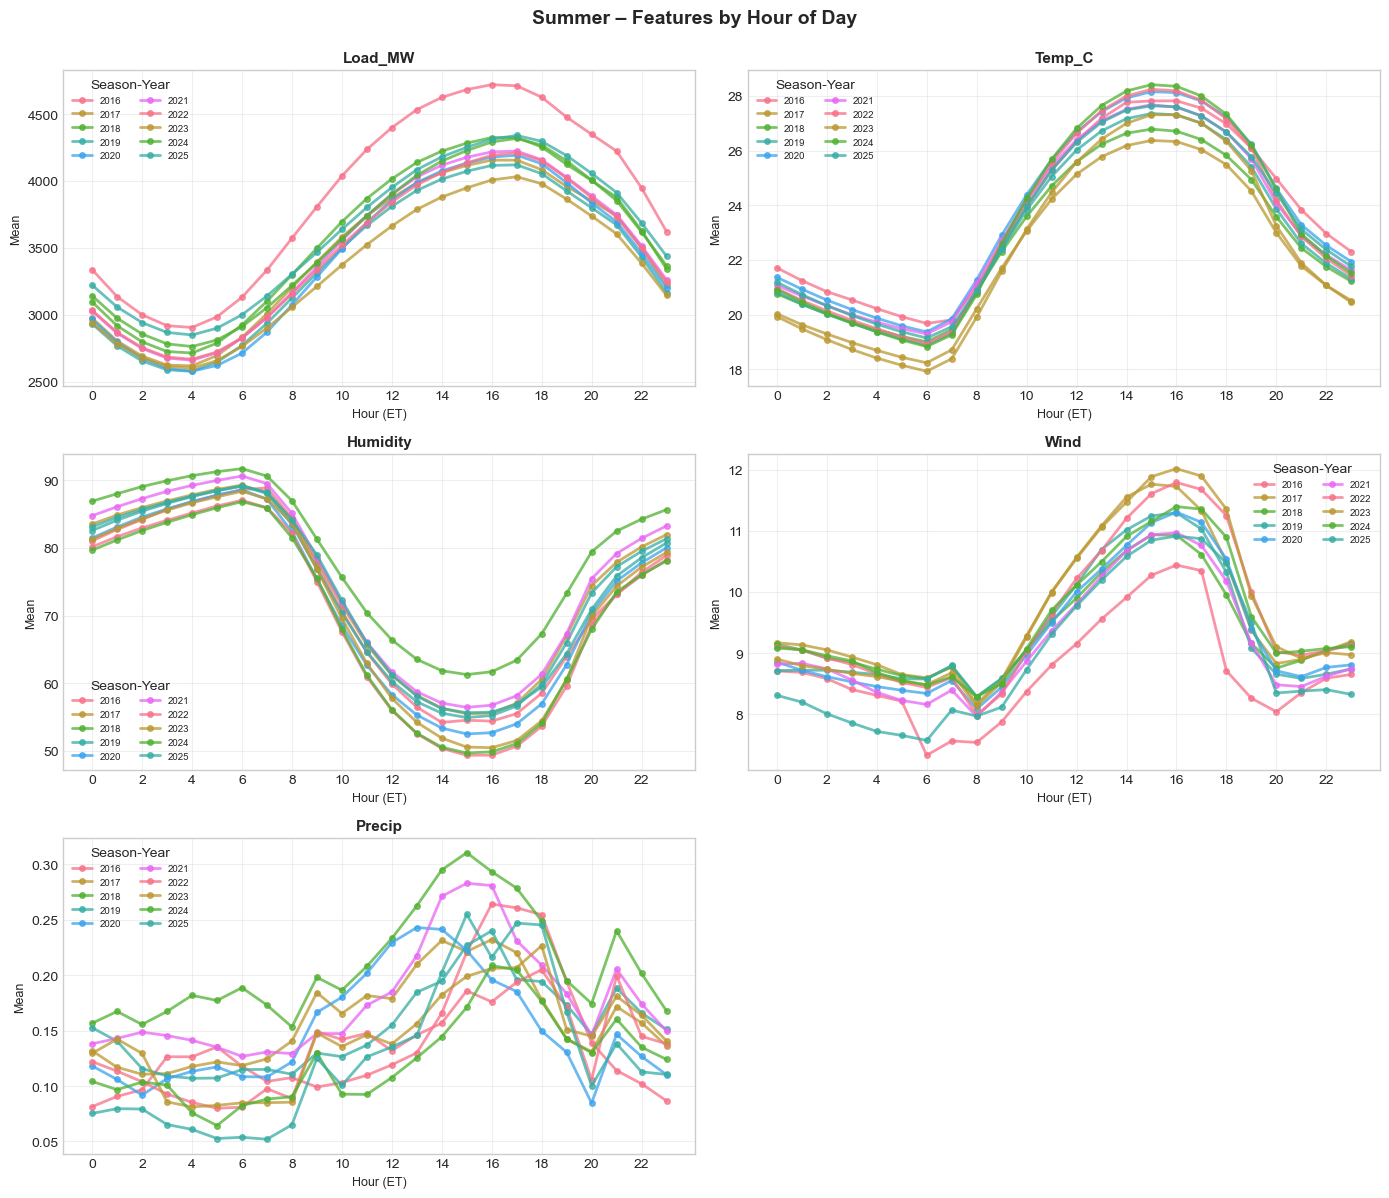

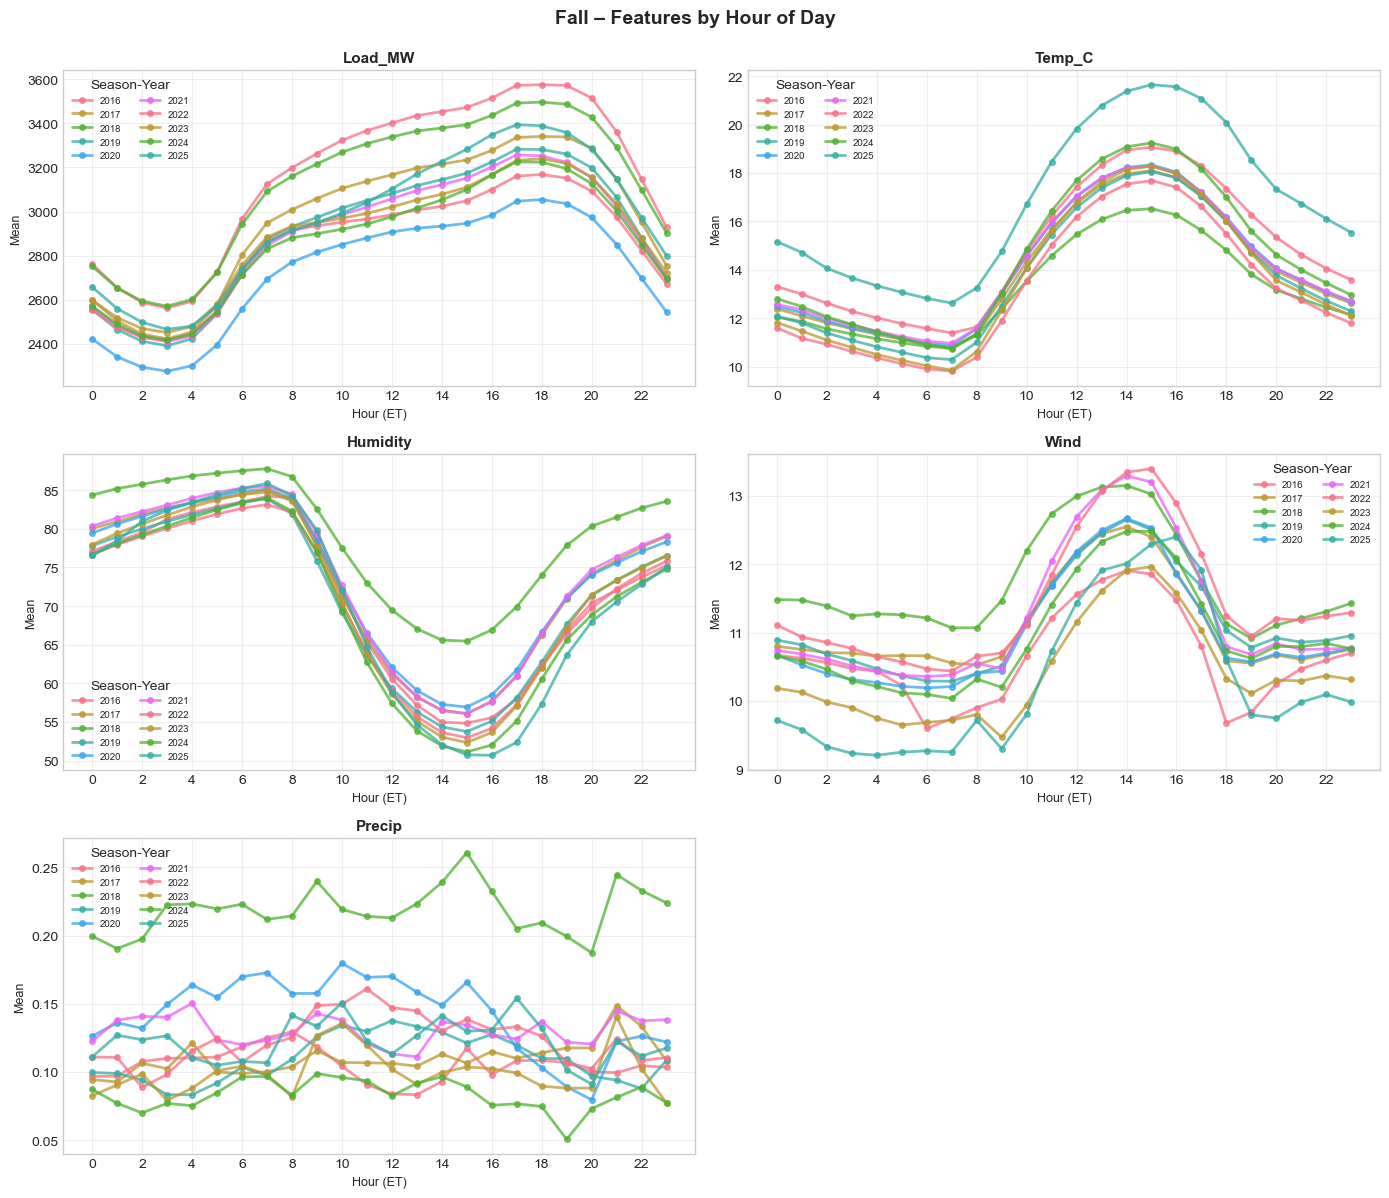

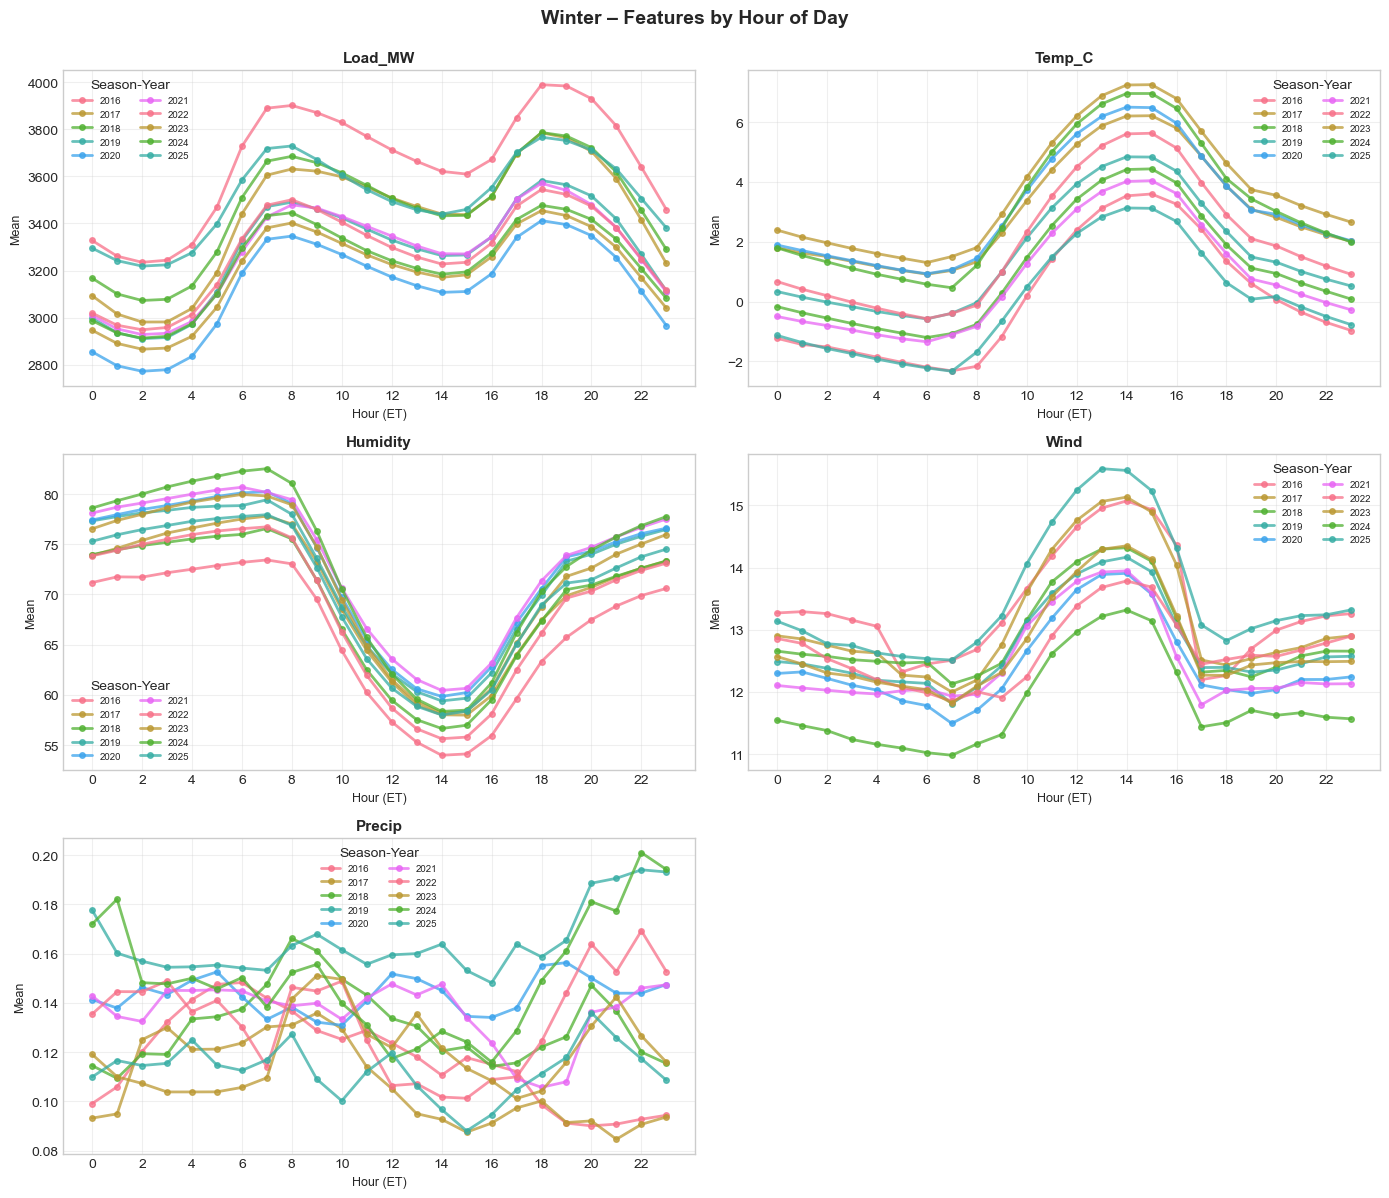

In [24]:
# Function to plot seasonal patterns by hour
def plot_seasonal_by_hour(season_name, data):
    """Plot seasonal patterns by hour of day"""
    season_data = data[data['season'] == season_name]
    
    fig, axes = plt.subplots(3, 2, figsize=(14, 12))
    axes = axes.flatten()
    metrics = ['Load_MW', 'Temp_C', 'Humidity', 'Wind', 'Precip']
    for idx, metric in enumerate(metrics):
        metric_data = season_data[season_data['Metric'] == metric]
        
        for year in sorted(metric_data['season_year'].unique()):
            year_data = metric_data[metric_data['season_year'] == year].sort_values('hour')
            axes[idx].plot(year_data['hour'], year_data['Value'], 
                          marker='o', label=str(year), alpha=0.75, linewidth=2, markersize=4)
        
        axes[idx].set_title(f'{metric}', fontsize=11, fontweight='bold')
        axes[idx].set_xlabel('Hour (ET)', fontsize=9)
        axes[idx].set_ylabel('Mean', fontsize=9)
        axes[idx].legend(title='Season-Year', fontsize=7, ncol=2)
        axes[idx].grid(True, alpha=0.3)
        axes[idx].set_xticks(range(0, 24, 2))
    
    fig.delaxes(axes[5])
    plt.suptitle(f'{season_name} – Features by Hour of Day', 
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    return fig
    plt.savefig(os.path.join(FIGURES_DIR, f'{season_name}_hour.png'), dpi=150, bbox_inches='tight')
    plt.show()

# Generate plots for all seasons
print("\nGenerating seasonal plots by hour...")
for season in ['Spring', 'Summer', 'Fall', 'Winter']:
    plot_seasonal_by_hour(season, hourly_tbl)
    print(f"  Saved: {season}_hour.png")

In [25]:
print("\n" + "=" * 70)
print("Seasonal analysis complete!")
print(f"Generated {len([f for f in os.listdir(FIGURES_DIR) if f.endswith('.png')])} plots")
print("=" * 70)


Seasonal analysis complete!
Generated 10 plots


## 4. Prepare Data for Model Training

In [27]:
print("\n" + "=" * 70)
print("STEP 4: PREPARING DATA FOR MODEL TRAINING")
print("=" * 70)

# Load merged data
df = pd.read_csv(os.path.join(PROCESSED_DIR, "merged_load_weather.csv"))

# Rename columns to standard names
df = df.rename(columns={
    'datetime_beginning_ept': 'datetime',
    'load_area': 'region',
    'mw': 'load',
    'temp': 'temperature',
    'precip': 'precipitation',
    'wind': 'wind_speed'
})

# Keep only necessary columns
keep_cols = ['datetime', 'region', 'load', 'temperature', 'humidity', 'precipitation', 'wind_speed']
df = df[keep_cols]

df['datetime'] = parse_et(df['datetime'])
df = df.dropna(subset=['datetime'])
df = df.sort_values('datetime').reset_index(drop=True)

print(f"\nData loaded: {len(df):,} rows")
print(f"Date range: {df['datetime'].min()} to {df['datetime'].max()}")
print(f"Regions: {df['region'].nunique()}")


STEP 4: PREPARING DATA FOR MODEL TRAINING

Data loaded: 2,452,044 rows
Date range: 2016-01-01 00:00:00-05:00 to 2025-10-30 23:00:00-04:00
Regions: 29


In [28]:
# Feature engineering function
def add_features(df):
    """Add temporal and calendar features"""
    df = df.copy()
    
    # ===== TEMPORAL FEATURES =====
    df['hour'] = df['datetime'].dt.hour
    df['day_of_week'] = df['datetime'].dt.dayofweek  # Monday=0, Sunday=6
    df['month'] = df['datetime'].dt.month
    df['day_of_month'] = df['datetime'].dt.day
    df['day_of_year'] = df['datetime'].dt.dayofyear
    df['week_of_year'] = df['datetime'].dt.isocalendar().week
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    
    # Cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    
    # ===== HOLIDAY FEATURES =====
    # Create US holiday calendar
    us_holidays = holidays.US(years=range(2016, 2026))
    df['date'] = df['datetime'].dt.date
    df['is_holiday'] = df['date'].apply(lambda x: int(x in us_holidays))
    
    # Day before/after holiday
    df['is_day_before_holiday'] = df['is_holiday'].shift(-24).fillna(0).astype(int)
    df['is_day_after_holiday'] = df['is_holiday'].shift(24).fillna(0).astype(int)
    
    # Thanksgiving - Cooking load, midday peak
    df['is_thanksgiving'] = df['date'].apply(
        lambda x: int(1 if us_holidays.get(x) == 'Thanksgiving' else 0)
    )
    
    # Christmas - Low commercial, high residential heating
    df['is_christmas'] = df['date'].apply(
        lambda x: int(1 if us_holidays.get(x) == 'Christmas Day' else 0)
    )
    
    # New Year's Day - Late night/early morning shift
    df['is_new_years'] = df['date'].apply(
        lambda x: int(1 if us_holidays.get(x) == "New Year's Day" else 0)
    )
    
    # July 4th - Summer, outdoor, evening grilling/fireworks
    df['is_july4'] = df['date'].apply(
        lambda x: int(1 if us_holidays.get(x) == 'Independence Day' else 0)
    )
    # Others
    df['is_other_holiday'] = (df['is_holiday']-df['is_thanksgiving']-df['is_christmas']-df['is_new_years']-df['is_july4'])
    
    return df

df = add_features(df)
print("\nFeature engineering complete")
print(f"Total features: {len(df.columns)}")


Feature engineering complete
Total features: 27


## 5. Task 1: Hourly Load Forecast - Best Model Finding

In [30]:
print("\n" + "=" * 70)
print("TASK 1: HOURLY LOAD FORECAST - BEST MODEL FINDING")
print("=" * 70)

FEATURE_COLS = [
    # Temporal
    'hour', 'day_of_week', 'month', 'day_of_month', 'day_of_year', 'week_of_year', 'is_weekend',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
    # Weather
    'temperature', 'humidity', 'wind_speed', 'precipitation',
    # 'is_holiday', 'is_day_before_holiday', 'is_day_after_holiday'
    'is_thanksgiving', 'is_christmas', 'is_new_years', 'is_july4', 'is_other_holiday', 'is_day_before_holiday', 'is_day_after_holiday'
]

TARGET_COL = 'load'
# Get list of regions
regions = sorted(df['region'].unique())
print(f"\nTraining models for {len(regions)} regions")

# Define training period
train_start = pd.to_datetime(TRAIN_START)
train_end = pd.to_datetime(TRAIN_END)
test_start = pd.to_datetime(TEST_START)
test_end = pd.to_datetime(TEST_END)
final_train_start = pd.to_datetime(FINAL_TRAIN_START)
final_train_end = pd.to_datetime(FINAL_TRAIN_END)

print(f"\nTraining period: {train_start} to {train_end}")
print(f"Testing period: {test_start} to {test_end}")


TASK 1: HOURLY LOAD FORECAST - BEST MODEL FINDING

Training models for 29 regions

Training period: 2016-01-01 00:00:00 to 2024-10-30 23:00:00
Testing period: 2024-11-20 00:00:00 to 2024-11-29 23:00:00


In [31]:
def get_models():
    """
    Define all models to be compared.
    Returns dict with model name and model object.
    """
    models = {
        '1. Linear + Interactions': None,  # Special handling needed
        '2. Random Forest': RandomForestRegressor(
            n_estimators=100,
            max_depth=20,
            min_samples_split=10,
            random_state=42,
            n_jobs=-1
        ),
        '3. XGBoost': XGBRegressor(
            n_estimators=100,
            max_depth=8,
            learning_rate=0.1,
            random_state=42,
            n_jobs=-1
        ),
        '4. LightGBM': LGBMRegressor(
            n_estimators=100,
            max_depth=8,
            learning_rate=0.1,
            random_state=42,
            n_jobs=-1,
            verbose=-1
        ),
        '5. CatBoost': CatBoostRegressor(
            iterations=100,
            depth=8,
            learning_rate=0.1,
            random_state=42,
            verbose=False
        )
    }
    return models

print("Model definitions created")

Model definitions created


In [32]:
def train_linear_with_interactions(X_train, y_train, X_test):
    """
    Simple linear regression with minimal categorical encoding.
    
    - No scaling
    - Only one-hot encode day_of_week (7 categories)
    - Keep hour and month as numeric (they have some ordinal meaning)
    - Focus on key interactions
    """
    X_train_df = pd.DataFrame(X_train, columns=FEATURE_COLS)
    X_test_df = pd.DataFrame(X_test, columns=FEATURE_COLS)
    
    # Only one-hot encode day_of_week
    X_train_df = pd.get_dummies(X_train_df, columns=['day_of_week'], drop_first=True)
    X_test_df = pd.get_dummies(X_test_df, columns=['day_of_week'], drop_first=True)
    
    # Align columns
    X_test_df = X_test_df.reindex(columns=X_train_df.columns, fill_value=0)
    
    # Key interactions
    X_train_df['hour_x_temp'] = X_train_df['hour'] * X_train_df['temperature']
    X_train_df['temp_squared'] = X_train_df['temperature'] ** 2
    X_train_df['temp_x_humidity'] = X_train_df['temperature'] * X_train_df['humidity']
    X_train_df['weekend_x_temp'] = X_train_df['is_weekend'] * X_train_df['temperature']
    
    X_test_df['hour_x_temp'] = X_test_df['hour'] * X_test_df['temperature']
    X_test_df['temp_squared'] = X_test_df['temperature'] ** 2
    X_test_df['temp_x_humidity'] = X_test_df['temperature'] * X_test_df['humidity']
    X_test_df['weekend_x_temp'] = X_test_df['is_weekend'] * X_test_df['temperature']
    
    # Train
    model = LinearRegression()
    model.fit(X_train_df, y_train)
    y_pred = model.predict(X_test_df)
    
    return model, y_pred

def calculate_metrics(y_true, y_pred):
    """
    Calculate regression metrics.
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }

def prepare_data(df, train_start, train_end, test_start, test_end, FEATURE_COLS, TARGET_COL, region=None):
    """
    Prepare train and test data for a given time period and region.
    """
    # Filter by region if specified
    if region is not None:
        df = df[df['region'] == region].copy()
    
    # Convert string dates to datetime
    train_start_dt = pd.Timestamp(train_start).tz_localize('America/New_York')
    train_end_dt = pd.Timestamp(train_end).tz_localize('America/New_York')
    test_start_dt = pd.Timestamp(test_start).tz_localize('America/New_York')
    test_end_dt = pd.Timestamp(test_end).tz_localize('America/New_York')
    
    # Split data
    train_data = df[(df['datetime'] >= train_start_dt) & (df['datetime'] <= train_end_dt)].copy()
    test_data = df[(df['datetime'] >= test_start_dt) & (df['datetime'] <= test_end_dt)].copy()
    
    # Drop rows with missing lag features
    train_data = train_data.dropna(subset=FEATURE_COLS)
    test_data = test_data.dropna(subset=FEATURE_COLS)
    
    # Prepare X and y
    X_train = train_data[FEATURE_COLS].values
    y_train = train_data[TARGET_COL].values
    X_test = test_data[FEATURE_COLS].values
    y_test = test_data[TARGET_COL].values
    
    return X_train, y_train, X_test, y_test, test_data

print("Helper functions defined")

Helper functions defined


In [33]:
# Get unique regions
regions = sorted(df['region'].unique())
print(f"Number of regions: {len(regions)}")
print(f"Regions: {regions}")

Number of regions: 29
Regions: ['AECO', 'AEPAPT', 'AEPIMP', 'AEPKPT', 'AEPOPT', 'AP', 'BC', 'CE', 'DAY', 'DEOK', 'DOM', 'DPLCO', 'DUQ', 'EASTON', 'EKPC', 'JC', 'ME', 'OE', 'OVEC', 'PAPWR', 'PE', 'PEPCO', 'PLCO', 'PN', 'PS', 'RECO', 'SMECO', 'UGI', 'VMEU']


In [34]:
# Compare all models across all regions
print("="*70)
print("MODEL COMPARISON (2024 TEST)")
print("="*70)

load_results = []
models_dict = get_models()

for region in tqdm(regions, desc="Processing regions"):
    print(f"\n{'='*70}")
    print(f"Region: {region}")
    print(f"{'='*70}")
    
    # Prepare data
    X_train, y_train, X_test, y_test, test_data = prepare_data(
        df, TRAIN_START, TRAIN_END,
        TEST_START, TEST_END, FEATURE_COLS, TARGET_COL,
        region=region
    )
    
    print(f"Train samples: {len(X_train):,}")
    print(f"Test samples: {len(X_test):,}")
    
    # Train and evaluate each model
    for model_name, model in models_dict.items():
        try:
            if model_name == '1. Linear + Interactions':
                # Special handling for linear with interactions
                model, y_pred = train_linear_with_interactions(X_train, y_train, X_test)
            else:
                # Train model
                model.fit(X_train, y_train)
                # Predict
                y_pred = model.predict(X_test)
            
            # Calculate metrics
            metrics = calculate_metrics(y_test, y_pred)
            
            # Store results
            load_results.append({
                'Region': region,
                'Method': model_name,
                'MSE': metrics['MSE'],
                'RMSE': metrics['RMSE'],
                'MAE': metrics['MAE'],
                'R2': metrics['R2'],
                'Train_Size': len(X_train),
                'Test_Size': len(X_test)
            })
            
            print(f"{model_name:30s} - RMSE: {metrics['RMSE']:8.2f}, MAE: {metrics['MAE']:8.2f}, R2: {metrics['R2']:6.4f}")
            
        except Exception as e:
            print(f"{model_name:30s} - ERROR: {str(e)}")

# Convert to DataFrame
load_results_df = pd.DataFrame(load_results)

print("\n" + "="*70)
print("Complete!")
print("="*70)

MODEL COMPARISON (2024 TEST)


Processing regions:   0%|                                | 0/29 [00:00<?, ?it/s]


Region: AECO
Train samples: 68,625
Test samples: 240
1. Linear + Interactions       - RMSE:    91.38, MAE:    73.81, R2: 0.3783
2. Random Forest               - RMSE:    54.34, MAE:    39.54, R2: 0.7802
3. XGBoost                     - RMSE:    53.39, MAE:    39.09, R2: 0.7878
4. LightGBM                    - RMSE:    52.98, MAE:    38.07, R2: 0.7910


Processing regions:   3%|▊                       | 1/29 [00:04<02:11,  4.71s/it]

5. CatBoost                    - RMSE:    54.68, MAE:    40.25, R2: 0.7774

Region: AEPAPT
Train samples: 77,407
Test samples: 240
1. Linear + Interactions       - RMSE:   373.44, MAE:   303.54, R2: 0.4473
2. Random Forest               - RMSE:   318.35, MAE:   260.87, R2: 0.5984
3. XGBoost                     - RMSE:   269.62, MAE:   216.45, R2: 0.7119
4. LightGBM                    - RMSE:   300.84, MAE:   241.28, R2: 0.6413


Processing regions:   7%|█▋                      | 2/29 [00:10<02:18,  5.14s/it]

5. CatBoost                    - RMSE:   287.72, MAE:   232.58, R2: 0.6719

Region: AEPIMP
Train samples: 77,407
Test samples: 240
1. Linear + Interactions       - RMSE:   195.98, MAE:   153.02, R2: 0.4975
2. Random Forest               - RMSE:   152.37, MAE:   126.54, R2: 0.6963
3. XGBoost                     - RMSE:   142.65, MAE:    99.15, R2: 0.7338
4. LightGBM                    - RMSE:   158.31, MAE:   104.08, R2: 0.6721


Processing regions:  10%|██▍                     | 3/29 [00:15<02:17,  5.28s/it]

5. CatBoost                    - RMSE:   141.27, MAE:   100.12, R2: 0.7389

Region: AEPKPT
Train samples: 77,407
Test samples: 240
1. Linear + Interactions       - RMSE:    50.26, MAE:    39.24, R2: 0.5514
2. Random Forest               - RMSE:    52.75, MAE:    41.71, R2: 0.5058
3. XGBoost                     - RMSE:    51.55, MAE:    40.23, R2: 0.5280
4. LightGBM                    - RMSE:    54.09, MAE:    43.38, R2: 0.4804


Processing regions:  14%|███▎                    | 4/29 [00:21<02:13,  5.34s/it]

5. CatBoost                    - RMSE:    52.15, MAE:    41.15, R2: 0.5170

Region: AEPOPT
Train samples: 77,407
Test samples: 240
1. Linear + Interactions       - RMSE:   742.26, MAE:   658.51, R2: -0.8363
2. Random Forest               - RMSE:   759.76, MAE:   691.32, R2: -0.9240
3. XGBoost                     - RMSE:   754.16, MAE:   694.81, R2: -0.8957
4. LightGBM                    - RMSE:   761.27, MAE:   695.56, R2: -0.9316


Processing regions:  17%|████▏                   | 5/29 [00:26<02:08,  5.34s/it]

5. CatBoost                    - RMSE:   718.19, MAE:   660.78, R2: -0.7192

Region: AP
Train samples: 77,407
Test samples: 240
1. Linear + Interactions       - RMSE:   375.32, MAE:   311.90, R2: 0.4706
2. Random Forest               - RMSE:   299.12, MAE:   239.30, R2: 0.6638
3. XGBoost                     - RMSE:   271.89, MAE:   228.01, R2: 0.7222
4. LightGBM                    - RMSE:   273.51, MAE:   232.86, R2: 0.7189


Processing regions:  21%|████▉                   | 6/29 [00:32<02:05,  5.45s/it]

5. CatBoost                    - RMSE:   286.80, MAE:   241.96, R2: 0.6909

Region: BC
Train samples: 77,407
Test samples: 240
1. Linear + Interactions       - RMSE:   310.45, MAE:   247.96, R2: 0.3254
2. Random Forest               - RMSE:   252.48, MAE:   204.61, R2: 0.5538
3. XGBoost                     - RMSE:   235.19, MAE:   198.97, R2: 0.6128
4. LightGBM                    - RMSE:   240.46, MAE:   200.34, R2: 0.5953


Processing regions:  24%|█████▊                  | 7/29 [00:38<02:05,  5.71s/it]

5. CatBoost                    - RMSE:   238.44, MAE:   197.80, R2: 0.6020

Region: CE
Train samples: 77,407
Test samples: 240
1. Linear + Interactions       - RMSE:   519.20, MAE:   411.65, R2: 0.7196
2. Random Forest               - RMSE:   479.83, MAE:   353.59, R2: 0.7605
3. XGBoost                     - RMSE:   503.31, MAE:   338.17, R2: 0.7365
4. LightGBM                    - RMSE:   502.89, MAE:   367.65, R2: 0.7370


Processing regions:  28%|██████▌                 | 8/29 [00:44<02:04,  5.93s/it]

5. CatBoost                    - RMSE:   474.95, MAE:   322.46, R2: 0.7654

Region: DAY
Train samples: 77,407
Test samples: 240
1. Linear + Interactions       - RMSE:   120.09, MAE:    96.85, R2: 0.6836
2. Random Forest               - RMSE:   109.03, MAE:    80.08, R2: 0.7392
3. XGBoost                     - RMSE:   109.88, MAE:    80.72, R2: 0.7351
4. LightGBM                    - RMSE:   115.89, MAE:    87.78, R2: 0.7053


Processing regions:  31%|███████▍                | 9/29 [00:51<02:06,  6.32s/it]

5. CatBoost                    - RMSE:    87.27, MAE:    66.45, R2: 0.8329

Region: DEOK
Train samples: 77,407
Test samples: 240
1. Linear + Interactions       - RMSE:   172.40, MAE:   139.56, R2: 0.6376
2. Random Forest               - RMSE:   160.30, MAE:   126.81, R2: 0.6867
3. XGBoost                     - RMSE:   147.79, MAE:   114.98, R2: 0.7337
4. LightGBM                    - RMSE:   144.59, MAE:   112.57, R2: 0.7451


Processing regions:  34%|███████▉               | 10/29 [00:58<02:00,  6.33s/it]

5. CatBoost                    - RMSE:   138.67, MAE:   108.45, R2: 0.7656

Region: DOM
Train samples: 77,407
Test samples: 240
1. Linear + Interactions       - RMSE:  2363.72, MAE:  2247.34, R2: -3.9095
2. Random Forest               - RMSE:  2421.27, MAE:  2304.62, R2: -4.1515
3. XGBoost                     - RMSE:  2462.52, MAE:  2366.25, R2: -4.3285
4. LightGBM                    - RMSE:  2401.50, MAE:  2302.87, R2: -4.0677


Processing regions:  38%|████████▋              | 11/29 [01:04<01:52,  6.26s/it]

5. CatBoost                    - RMSE:  2405.45, MAE:  2315.21, R2: -4.0844

Region: DPLCO
Train samples: 77,407
Test samples: 240
1. Linear + Interactions       - RMSE:   132.25, MAE:   108.39, R2: 0.6367
2. Random Forest               - RMSE:   100.62, MAE:    84.86, R2: 0.7897
3. XGBoost                     - RMSE:    96.11, MAE:    76.89, R2: 0.8081
4. LightGBM                    - RMSE:    97.85, MAE:    80.25, R2: 0.8011


Processing regions:  41%|█████████▌             | 12/29 [01:09<01:43,  6.08s/it]

5. CatBoost                    - RMSE:   103.33, MAE:    86.03, R2: 0.7782

Region: DUQ
Train samples: 77,407
Test samples: 240
1. Linear + Interactions       - RMSE:    83.21, MAE:    63.87, R2: 0.5358
2. Random Forest               - RMSE:    49.96, MAE:    38.88, R2: 0.8327
3. XGBoost                     - RMSE:    49.28, MAE:    40.25, R2: 0.8372
4. LightGBM                    - RMSE:    53.97, MAE:    45.09, R2: 0.8048


Processing regions:  45%|██████████▎            | 13/29 [01:15<01:36,  6.03s/it]

5. CatBoost                    - RMSE:    54.21, MAE:    44.64, R2: 0.8030

Region: EASTON
Train samples: 77,407
Test samples: 240
1. Linear + Interactions       - RMSE:     2.08, MAE:     1.64, R2: 0.6714
2. Random Forest               - RMSE:     1.91, MAE:     1.57, R2: 0.7216
3. XGBoost                     - RMSE:     1.81, MAE:     1.46, R2: 0.7522
4. LightGBM                    - RMSE:     1.85, MAE:     1.51, R2: 0.7414


Processing regions:  48%|███████████            | 14/29 [01:21<01:30,  6.00s/it]

5. CatBoost                    - RMSE:     1.69, MAE:     1.33, R2: 0.7838

Region: EKPC
Train samples: 77,407
Test samples: 240
1. Linear + Interactions       - RMSE:   196.27, MAE:   163.75, R2: 0.2809
2. Random Forest               - RMSE:   167.40, MAE:   144.90, R2: 0.4769
3. XGBoost                     - RMSE:   169.50, MAE:   145.63, R2: 0.4637
4. LightGBM                    - RMSE:   166.31, MAE:   144.61, R2: 0.4837


Processing regions:  52%|███████████▉           | 15/29 [01:27<01:22,  5.86s/it]

5. CatBoost                    - RMSE:   168.57, MAE:   146.03, R2: 0.4696

Region: JC
Train samples: 77,407
Test samples: 240
1. Linear + Interactions       - RMSE:   173.56, MAE:   143.57, R2: 0.6056
2. Random Forest               - RMSE:   126.47, MAE:    92.14, R2: 0.7906
3. XGBoost                     - RMSE:   101.73, MAE:    79.19, R2: 0.8645
4. LightGBM                    - RMSE:   116.91, MAE:    89.30, R2: 0.8210


Processing regions:  55%|████████████▋          | 16/29 [01:33<01:15,  5.82s/it]

5. CatBoost                    - RMSE:   112.87, MAE:    86.82, R2: 0.8332

Region: ME
Train samples: 77,407
Test samples: 240
1. Linear + Interactions       - RMSE:   137.13, MAE:   104.40, R2: 0.3850
2. Random Forest               - RMSE:   148.12, MAE:   112.15, R2: 0.2824
3. XGBoost                     - RMSE:   123.47, MAE:    89.35, R2: 0.5013
4. LightGBM                    - RMSE:   125.86, MAE:    90.35, R2: 0.4819


Processing regions:  59%|█████████████▍         | 17/29 [01:38<01:09,  5.80s/it]

5. CatBoost                    - RMSE:   121.67, MAE:    91.54, R2: 0.5158

Region: OE
Train samples: 77,407
Test samples: 240
1. Linear + Interactions       - RMSE:   356.36, MAE:   293.59, R2: 0.6705
2. Random Forest               - RMSE:   337.67, MAE:   251.06, R2: 0.7042
3. XGBoost                     - RMSE:   303.04, MAE:   231.03, R2: 0.7618
4. LightGBM                    - RMSE:   283.93, MAE:   232.26, R2: 0.7909


Processing regions:  62%|██████████████▎        | 18/29 [01:44<01:02,  5.73s/it]

5. CatBoost                    - RMSE:   265.89, MAE:   216.38, R2: 0.8166

Region: OVEC
Train samples: 51,853
Test samples: 240
1. Linear + Interactions       - RMSE:     8.55, MAE:     6.33, R2: 0.1033
2. Random Forest               - RMSE:     9.76, MAE:     7.58, R2: -0.1672
3. XGBoost                     - RMSE:     8.70, MAE:     6.46, R2: 0.0729
4. LightGBM                    - RMSE:     8.48, MAE:     6.30, R2: 0.1191


Processing regions:  66%|███████████████        | 19/29 [01:48<00:51,  5.13s/it]

5. CatBoost                    - RMSE:     8.31, MAE:     6.06, R2: 0.1534

Region: PAPWR
Train samples: 77,407
Test samples: 240
1. Linear + Interactions       - RMSE:    58.67, MAE:    49.26, R2: 0.1402
2. Random Forest               - RMSE:    47.73, MAE:    37.19, R2: 0.4310
3. XGBoost                     - RMSE:    46.58, MAE:    37.65, R2: 0.4579
4. LightGBM                    - RMSE:    55.54, MAE:    45.73, R2: 0.2294


Processing regions:  69%|███████████████▊       | 20/29 [01:53<00:47,  5.31s/it]

5. CatBoost                    - RMSE:    51.42, MAE:    41.25, R2: 0.3395

Region: PE
Train samples: 77,407
Test samples: 240
1. Linear + Interactions       - RMSE:   231.09, MAE:   187.30, R2: 0.7087
2. Random Forest               - RMSE:   234.96, MAE:   187.10, R2: 0.6989
3. XGBoost                     - RMSE:   196.34, MAE:   155.24, R2: 0.7897
4. LightGBM                    - RMSE:   192.98, MAE:   152.87, R2: 0.7969


Processing regions:  72%|████████████████▋      | 21/29 [01:59<00:43,  5.39s/it]

5. CatBoost                    - RMSE:   187.37, MAE:   152.22, R2: 0.8085

Region: PEPCO
Train samples: 77,407
Test samples: 240
1. Linear + Interactions       - RMSE:   198.49, MAE:   164.58, R2: 0.5557
2. Random Forest               - RMSE:   212.07, MAE:   185.58, R2: 0.4928
3. XGBoost                     - RMSE:   202.17, MAE:   174.54, R2: 0.5390
4. LightGBM                    - RMSE:   188.49, MAE:   158.82, R2: 0.5993


Processing regions:  76%|█████████████████▍     | 22/29 [02:05<00:38,  5.47s/it]

5. CatBoost                    - RMSE:   179.06, MAE:   153.19, R2: 0.6384

Region: PLCO
Train samples: 77,407
Test samples: 240
1. Linear + Interactions       - RMSE:   265.62, MAE:   213.59, R2: 0.6265
2. Random Forest               - RMSE:   298.90, MAE:   223.11, R2: 0.5271
3. XGBoost                     - RMSE:   220.52, MAE:   166.43, R2: 0.7426
4. LightGBM                    - RMSE:   239.97, MAE:   184.99, R2: 0.6952


Processing regions:  79%|██████████████████▏    | 23/29 [02:10<00:33,  5.56s/it]

5. CatBoost                    - RMSE:   230.78, MAE:   181.83, R2: 0.7181

Region: PN
Train samples: 77,407
Test samples: 240
1. Linear + Interactions       - RMSE:   149.73, MAE:   121.57, R2: 0.4017
2. Random Forest               - RMSE:   140.40, MAE:   117.34, R2: 0.4739
3. XGBoost                     - RMSE:   143.47, MAE:   119.59, R2: 0.4506
4. LightGBM                    - RMSE:   134.11, MAE:   107.20, R2: 0.5200


Processing regions:  83%|███████████████████    | 24/29 [02:17<00:28,  5.74s/it]

5. CatBoost                    - RMSE:   128.81, MAE:   103.86, R2: 0.5571

Region: PS
Train samples: 77,407
Test samples: 240
1. Linear + Interactions       - RMSE:   254.02, MAE:   207.95, R2: 0.6689
2. Random Forest               - RMSE:   227.23, MAE:   161.49, R2: 0.7350
3. XGBoost                     - RMSE:   206.49, MAE:   143.93, R2: 0.7812
4. LightGBM                    - RMSE:   217.44, MAE:   154.91, R2: 0.7574


Processing regions:  86%|███████████████████▊   | 25/29 [02:24<00:25,  6.39s/it]

5. CatBoost                    - RMSE:   198.63, MAE:   140.11, R2: 0.7975

Region: RECO
Train samples: 77,407
Test samples: 240
1. Linear + Interactions       - RMSE:     9.37, MAE:     7.61, R2: 0.6727
2. Random Forest               - RMSE:     8.51, MAE:     6.65, R2: 0.7299
3. XGBoost                     - RMSE:     7.36, MAE:     5.51, R2: 0.7984
4. LightGBM                    - RMSE:     7.63, MAE:     5.55, R2: 0.7832


Processing regions:  90%|████████████████████▌  | 26/29 [02:31<00:19,  6.57s/it]

5. CatBoost                    - RMSE:     7.01, MAE:     5.34, R2: 0.8169

Region: SMECO
Train samples: 77,407
Test samples: 240
1. Linear + Interactions       - RMSE:    31.66, MAE:    25.18, R2: 0.7116
2. Random Forest               - RMSE:    26.43, MAE:    20.23, R2: 0.7991
3. XGBoost                     - RMSE:    24.70, MAE:    19.74, R2: 0.8245
4. LightGBM                    - RMSE:    26.19, MAE:    20.72, R2: 0.8027


Processing regions:  93%|█████████████████████▍ | 27/29 [02:40<00:14,  7.20s/it]

5. CatBoost                    - RMSE:    25.94, MAE:    20.74, R2: 0.8065

Region: UGI
Train samples: 77,407
Test samples: 240
1. Linear + Interactions       - RMSE:     7.87, MAE:     6.50, R2: 0.7018
2. Random Forest               - RMSE:     7.06, MAE:     5.44, R2: 0.7599
3. XGBoost                     - RMSE:     6.12, MAE:     4.81, R2: 0.8195
4. LightGBM                    - RMSE:     6.34, MAE:     5.00, R2: 0.8064


Processing regions:  97%|██████████████████████▏| 28/29 [02:46<00:06,  6.95s/it]

5. CatBoost                    - RMSE:     6.50, MAE:     5.26, R2: 0.7970

Region: VMEU
Train samples: 65,002
Test samples: 240
1. Linear + Interactions       - RMSE:     8.94, MAE:     6.98, R2: -0.0617
2. Random Forest               - RMSE:     7.06, MAE:     5.32, R2: 0.3375
3. XGBoost                     - RMSE:     7.09, MAE:     5.50, R2: 0.3333
4. LightGBM                    - RMSE:     7.02, MAE:     5.35, R2: 0.3450


Processing regions: 100%|███████████████████████| 29/29 [02:52<00:00,  5.94s/it]

5. CatBoost                    - RMSE:     7.02, MAE:     5.42, R2: 0.3463

Complete!


In [35]:
# Overall summary by method (averaged across all regions)
load_results_summary = load_results_df.groupby('Method').agg({
    'MSE': 'mean',
    'RMSE': 'mean',
    'MAE': 'mean',
    'R2': 'mean'
}).round(2)

load_results_summary = load_results_summary.sort_values('RMSE')

print("\n" + "="*70)
print("SUMMARY: Average Performance Across All Regions")
print("="*70)
print(load_results_summary)

# Best method overall
best_method_overall = load_results_summary.index[0]
print(f"\nBest Overall Method: {best_method_overall}")


SUMMARY: Average Performance Across All Regions
                                MSE    RMSE     MAE    R2
Method                                                   
5. CatBoost               245594.45  232.57  200.53  0.46
3. XGBoost                258616.19  238.50  204.14  0.44
4. LightGBM               249579.56  239.21  205.42  0.43
2. Random Forest          256822.46  248.69  212.12  0.39
1. Linear + Interactions  254198.18  262.74  226.19  0.31

Best Overall Method: 5. CatBoost


In [62]:
# Now retrain the best method for all regions and save
print(f"\nRetraining best method ({best_method_overall}) for all regions...")

hourly_best_models = {}  # Store trained models

for region in tqdm(regions, desc="Training best models"):
    # Prepare data
    X_train, y_train, X_test, y_test, test_data = prepare_data(
        df, FINAL_TRAIN_START, FINAL_TRAIN_END, 
        TEST_START, TEST_END, FEATURE_COLS, TARGET_COL,
        region=region
    )
    
    try:
        # Get the best method
        methods = get_models()
        model = methods[best_method_overall]
        
        if best_method_overall == '1. Linear + Interactions':
            model= train_linear_with_interactions(X_train, y_train, X_test)
            
            # Store both model and poly transformer
            hourly_best_models[region] = {
                'model': model,
                'method': best_method_overall,
                'feature_cols': FEATURE_COLS
            }
        else:
            model.fit(X_train, y_train)
            
            hourly_best_models[region] = {
                'model': model,
                'method': best_method_overall,
                'feature_cols': FEATURE_COLS
            }
    
    except Exception as e:
        print(f"Error training {best_method_overall} for {region}: {e}")
        continue

print(f"Trained best model for {len(hourly_best_models)} regions")


Retraining best method (5. CatBoost) for all regions...


Training best models: 100%|█████████████████████| 29/29 [00:18<00:00,  1.58it/s]

Trained best model for 29 regions


## 6. Task 2: Peak Hour Prediction - Best Model Finding

In [63]:
# Create peak hour labels for each day-region combination
print("Creating peak hour labels...")

peak_indices = df.groupby(['region', 'date'])['load'].idxmax()
df['is_peak_hour'] = 0
df.loc[peak_indices, 'is_peak_hour'] = 1

# Store actual peak hour for each day-region
df['peak_hour_actual'] = df.groupby(['region', 'date'])['hour'].transform(
    lambda x: x[df.loc[x.index, 'is_peak_hour'] == 1].iloc[0] if any(df.loc[x.index, 'is_peak_hour'] == 1) else -1
)

print(f"Peak hours labeled: {df['is_peak_hour'].sum():,}")

# Drop temporary date column for now (will recreate when needed)
df = df.drop('date', axis=1)

Creating peak hour labels...
Peak hours labeled: 102,191


In [89]:
print("\n" + "=" * 70)
print("TASK 2: PEAK HOUR PREDICTION - BEST MODEL FINDING")
print("=" * 70)

et_tz = pytz.timezone('America/New_York')
p1_train_end = pd.to_datetime(TRAIN_END).tz_localize(et_tz)
p1_final_train_end= pd.to_datetime(FINAL_TRAIN_END).tz_localize(et_tz)
p1_test_start = pd.to_datetime(TEST_START).tz_localize(et_tz)
p1_test_end = pd.to_datetime(TEST_END).tz_localize(et_tz)

p1_train = df[df['datetime'] <= p1_train_end].copy()
p1_final_train = df[df['datetime'] <= p1_final_train_end].copy()
p1_test = df[(df['datetime'] >= p1_test_start) & 
             (df['datetime'] <= p1_test_end)].copy()

# Add date column for grouping
p1_test['date'] = p1_test['datetime'].dt.date

print(f"Training: {len(p1_train):,} rows")
print(f"Test: {len(p1_test):,} rows")
print(f"Test days: {p1_test['date'].nunique()}")
print(f"Test predictions needed: {len(regions)} regions × {p1_test['date'].nunique()} days = {len(regions) * p1_test['date'].nunique()}")

print(f"\nPeak hour data prepared")


TASK 2: PEAK HOUR PREDICTION - BEST MODEL FINDING
Training: 2,198,062 rows
Test: 6,960 rows
Test days: 10
Test predictions needed: 29 regions × 10 days = 290

Peak hour data prepared


In [91]:
# Define methods for peak hour
def get_peak_hour_methods():
    return {
        '1. Linear + Interactions': 'regression',  # Will use regression to predict load
        '2. Random Forest': RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1),
        '3. XGBoost': XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, n_jobs=-1, eval_metric='logloss'),
        '4. LightGBM': LGBMClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, n_jobs=-1, verbose=-1),
        '5. Historical Same Date': 'historical'  # Look at same calendar date in previous years
    }

print("Methods defined for peak hour prediction")

Methods defined for peak hour prediction


### Method 1: Linear Regression with Interactions

In [94]:
print("\nTraining Method 1: Linear Regression with Interactions...")

p1_m1_results = []

for region in tqdm(regions, desc="Method 1"):
    try:
        # Train data for this region
        region_train = p1_train[p1_train['region'] == region].dropna(subset=FEATURE_COLS + ['load'])
        region_test = p1_test[p1_test['region'] == region].dropna(subset=FEATURE_COLS)
        
        if len(region_train) < 100 or len(region_test) == 0:
            continue
        
        X_train = region_train[FEATURE_COLS].values
        y_train = region_train['load'].values
        X_test = region_test[FEATURE_COLS].values
        
        # Train and predict in one call
        _, y_pred = train_linear_with_interactions(X_train, y_train, X_test)
        
        # For each day, find hour with max predicted load
        region_test_copy = region_test.copy()
        region_test_copy['predicted_load'] = y_pred
        
        for date in region_test_copy['date'].unique():
            day_data = region_test_copy[region_test_copy['date'] == date]
            
            # Predicted peak hour = hour with max predicted load
            pred_peak_hour = day_data.loc[day_data['predicted_load'].idxmax(), 'hour']
            
            # Actual peak hour
            actual_peak_hour = day_data.loc[day_data['load'].idxmax(), 'hour']
            
            # Check success
            success = np.abs(pred_peak_hour - actual_peak_hour) <= 1
            
            p1_m1_results.append({
                'region': region,
                'date': date,
                'pred': pred_peak_hour,
                'actual': actual_peak_hour,
                'correct': success
            })
        
    except Exception as e:
        print(f"Error with region {region}: {e}")
        continue

p1_m1_df = pd.DataFrame(p1_m1_results)
m1_success_rate = p1_m1_df['correct'].mean() * 100
print(f"\nMethod 1 Success Rate: {m1_success_rate:.2f}%")
print(f"Correct: {p1_m1_df['correct'].sum()}/{len(p1_m1_df)}")


Training Method 1: Linear Regression with Interactions...


Method 1: 100%|█████████████████████████████████| 29/29 [00:06<00:00,  4.17it/s]


Method 1 Success Rate: 36.21%
Correct: 105/290


### Method 2: Random Forest Classification

In [96]:
print("\nTraining Method 2: Random Forest Classification...")

p1_m2_models = {}
p1_m2_results = []

for region in tqdm(regions, desc="Method 2 Training"):
    try:
        region_train = p1_train[p1_train['region'] == region].dropna(subset=FEATURE_COLS + ['is_peak_hour'])
        
        if len(region_train) < 100:
            continue
        
        X_train = region_train[FEATURE_COLS]
        y_train = region_train['is_peak_hour']
        
        model = RandomForestClassifier(
            n_estimators=100,
            max_depth=15,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        )
        model.fit(X_train, y_train)
        
        p1_m2_models[region] = model
        
    except Exception as e:
        print(f"Error training region {region}: {e}")
        continue

print(f"Trained: {len(p1_m2_models)} models")

# Make predictions
print("Making predictions for Method 2...")
for region in tqdm(regions, desc="Method 2 Predictions"):
    if region not in p1_m2_models:
        continue
    
    region_test = p1_test[p1_test['region'] == region].dropna(subset=FEATURE_COLS)
    
    if len(region_test) == 0:
        continue
    
    X_test = region_test[FEATURE_COLS]
    y_pred_proba = p1_m2_models[region].predict_proba(X_test)[:, 1]
    
    # For each day, find hour with highest probability
    region_test_copy = region_test.copy()
    region_test_copy['peak_prob'] = y_pred_proba
    
    for date in region_test_copy['date'].unique():
        day_data = region_test_copy[region_test_copy['date'] == date]
        
        pred_peak_hour = day_data.loc[day_data['peak_prob'].idxmax(), 'hour']
        actual_peak_hour = day_data.loc[day_data['load'].idxmax(), 'hour']
        
        success = np.abs(pred_peak_hour - actual_peak_hour) <= 1
        
        p1_m2_results.append({
            'region': region,
            'date': date,
            'pred': pred_peak_hour,
            'actual': actual_peak_hour,
            'correct': success
        })

p1_m2_df = pd.DataFrame(p1_m2_results)
m2_success_rate = p1_m2_df['correct'].mean() * 100
print(f"\nMethod 2 Success Rate: {m2_success_rate:.2f}%")
print(f"Correct: {p1_m2_df['correct'].sum()}/{len(p1_m2_df)}")


Training Method 2: Random Forest Classification...


Method 2 Training: 100%|████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


Trained: 29 models
Making predictions for Method 2...


Method 2 Predictions: 100%|█████████████████████| 29/29 [00:00<00:00, 59.54it/s]


Method 2 Success Rate: 69.31%
Correct: 201/290


### Method 3: XGBoost Classification

In [98]:
print("\nTraining Method 3: XGBoost Classification...")

p1_m3_models = {}
p1_m3_results = []

for region in tqdm(regions, desc="Method 3 Training"):
    try:
        region_train = p1_train[p1_train['region'] == region].dropna(subset=FEATURE_COLS + ['is_peak_hour'])
        
        if len(region_train) < 100:
            continue
        
        X_train = region_train[FEATURE_COLS]
        y_train = region_train['is_peak_hour']
        
        # Calculate scale_pos_weight for imbalanced classes
        scale_pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()
        
        model = XGBClassifier(
            n_estimators=100,
            max_depth=8,
            learning_rate=0.1,
            scale_pos_weight=scale_pos_weight,
            random_state=42,
            n_jobs=-1
        )
        model.fit(X_train, y_train)
        
        p1_m3_models[region] = model
        
    except Exception as e:
        print(f"Error training region {region}: {e}")
        continue

print(f"Trained: {len(p1_m3_models)} models")

# Make predictions
print("Making predictions for Method 3...")
for region in tqdm(regions, desc="Method 3 Predictions"):
    if region not in p1_m3_models:
        continue
    
    region_test = p1_test[p1_test['region'] == region].dropna(subset=FEATURE_COLS)
    
    if len(region_test) == 0:
        continue
    
    X_test = region_test[FEATURE_COLS]
    y_pred_proba = p1_m3_models[region].predict_proba(X_test)[:, 1]
    
    region_test_copy = region_test.copy()
    region_test_copy['peak_prob'] = y_pred_proba
    
    for date in region_test_copy['date'].unique():
        day_data = region_test_copy[region_test_copy['date'] == date]
        
        pred_peak_hour = day_data.loc[day_data['peak_prob'].idxmax(), 'hour']
        actual_peak_hour = day_data.loc[day_data['load'].idxmax(), 'hour']
        
        success = np.abs(pred_peak_hour - actual_peak_hour) <= 1
        
        p1_m3_results.append({
            'region': region,
            'date': date,
            'pred': pred_peak_hour,
            'actual': actual_peak_hour,
            'correct': success
        })

p1_m3_df = pd.DataFrame(p1_m3_results)
m3_success_rate = p1_m3_df['correct'].mean() * 100
print(f"\nMethod 3 Success Rate: {m3_success_rate:.2f}%")
print(f"Correct: {p1_m3_df['correct'].sum()}/{len(p1_m3_df)}")


Training Method 3: XGBoost Classification...


Method 3 Training: 100%|████████████████████████| 29/29 [00:07<00:00,  3.75it/s]


Trained: 29 models
Making predictions for Method 3...


Method 3 Predictions: 100%|████████████████████| 29/29 [00:00<00:00, 267.74it/s]


Method 3 Success Rate: 70.69%
Correct: 205/290


### Method 4: LightGBM Classification

In [100]:
print("\nTraining Method 4: LightGBM Classification...")

p1_m4_models = {}
p1_m4_results = []

for region in tqdm(regions, desc="Method 4 Training"):
    try:
        region_train = p1_train[p1_train['region'] == region].dropna(subset=FEATURE_COLS + ['is_peak_hour'])
        
        if len(region_train) < 100:
            continue
        
        X_train = region_train[FEATURE_COLS]
        y_train = region_train['is_peak_hour']
        
        model = LGBMClassifier(
            n_estimators=100,
            max_depth=8,
            learning_rate=0.1,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1,
            verbose=-1
        )
        model.fit(X_train, y_train)
        
        p1_m4_models[region] = model
        
    except Exception as e:
        print(f"Error training region {region}: {e}")
        continue

print(f"Trained: {len(p1_m4_models)} models")

# Make predictions
print("Making predictions for Method 4...")
for region in tqdm(regions, desc="Method 4 Predictions"):
    if region not in p1_m4_models:
        continue
    
    region_test = p1_test[p1_test['region'] == region].dropna(subset=FEATURE_COLS)
    
    if len(region_test) == 0:
        continue
    
    X_test = region_test[FEATURE_COLS]
    y_pred_proba = p1_m4_models[region].predict_proba(X_test)[:, 1]
    
    region_test_copy = region_test.copy()
    region_test_copy['peak_prob'] = y_pred_proba
    
    for date in region_test_copy['date'].unique():
        day_data = region_test_copy[region_test_copy['date'] == date]
        
        pred_peak_hour = day_data.loc[day_data['peak_prob'].idxmax(), 'hour']
        actual_peak_hour = day_data.loc[day_data['load'].idxmax(), 'hour']
        
        success = np.abs(pred_peak_hour - actual_peak_hour) <= 1
        
        p1_m4_results.append({
            'region': region,
            'date': date,
            'pred': pred_peak_hour,
            'actual': actual_peak_hour,
            'correct': success
        })

p1_m4_df = pd.DataFrame(p1_m4_results)
m4_success_rate = p1_m4_df['correct'].mean() * 100
print(f"\nMethod 4 Success Rate: {m4_success_rate:.2f}%")
print(f"Correct: {p1_m4_df['correct'].sum()}/{len(p1_m4_df)}")


Training Method 4: LightGBM Classification...


Method 4 Training: 100%|████████████████████████| 29/29 [00:06<00:00,  4.36it/s]


Trained: 29 models
Making predictions for Method 4...


Method 4 Predictions: 100%|████████████████████| 29/29 [00:00<00:00, 265.00it/s]


Method 4 Success Rate: 68.28%
Correct: 198/290


### Method 5: Historical Same Calendar Date

In [102]:
print("\nMethod 5: Historical Same Calendar Date...")

p1_m5_results = []

for region in tqdm(regions, desc="Method 5"):
    region_test = p1_test[p1_test['region'] == region]
    region_train = p1_train[p1_train['region'] == region]
    
    if len(region_test) == 0:
        continue
    
    for date in region_test['date'].unique():
        # Get the same calendar date from previous years
        test_date = pd.Timestamp(date)
        month = test_date.month
        day = test_date.day
        
        # Find historical same calendar dates
        historical = region_train[
            (region_train['datetime'].dt.month == month) &
            (region_train['datetime'].dt.day == day)
        ]
        
        if len(historical) == 0:
            # Fallback to mode of peak hours in training data
            pred_peak_hour = region_train.groupby('date')['hour'].apply(
                lambda x: x[region_train.loc[x.index, 'load'].idxmax()]
            ).mode().iloc[0] if len(region_train) > 0 else 17
        else:
            # Find most common peak hour on this calendar date
            historical_dates = historical['datetime'].dt.date.unique()
            peak_hours = []
            for hist_date in historical_dates:
                day_data = historical[historical['datetime'].dt.date == hist_date]
                if len(day_data) > 0:
                    peak_hours.append(day_data.loc[day_data['load'].idxmax(), 'hour'])
            
            if peak_hours:
                pred_peak_hour = pd.Series(peak_hours).mode().iloc[0]
            else:
                pred_peak_hour = 17  # Default fallback
        
        # Get actual peak hour
        day_data = region_test[region_test['date'] == date]
        actual_peak_hour = day_data.loc[day_data['load'].idxmax(), 'hour']
        
        success = np.abs(pred_peak_hour - actual_peak_hour) <= 1
        
        p1_m5_results.append({
            'region': region,
            'date': date,
            'pred': pred_peak_hour,
            'actual': actual_peak_hour,
            'correct': success
        })

p1_m5_df = pd.DataFrame(p1_m5_results)
m5_success_rate = p1_m5_df['correct'].mean() * 100
print(f"\nMethod 5 Success Rate: {m5_success_rate:.2f}%")
print(f"Correct: {p1_m5_df['correct'].sum()}/{len(p1_m5_df)}")


Method 5: Historical Same Calendar Date...


Method 5: 100%|█████████████████████████████████| 29/29 [00:03<00:00,  7.52it/s]


Method 5 Success Rate: 51.03%
Correct: 148/290


In [103]:
# Compile Phase 1 results
p1_comparison = pd.DataFrame([
    {
        'Method': '1. Linear + Interactions',
        'Total': len(p1_m1_df),
        'Correct': p1_m1_df['correct'].sum(),
        'Incorrect': len(p1_m1_df) - p1_m1_df['correct'].sum(),
        'Success_Rate_%': m1_success_rate
    },
    {
        'Method': '2. Random Forest',
        'Total': len(p1_m2_df),
        'Correct': p1_m2_df['correct'].sum(),
        'Incorrect': len(p1_m2_df) - p1_m2_df['correct'].sum(),
        'Success_Rate_%': m2_success_rate
    },
    {
        'Method': '3. XGBoost',
        'Total': len(p1_m3_df),
        'Correct': p1_m3_df['correct'].sum(),
        'Incorrect': len(p1_m3_df) - p1_m3_df['correct'].sum(),
        'Success_Rate_%': m3_success_rate
    },
    {
        'Method': '4. LightGBM',
        'Total': len(p1_m4_df),
        'Correct': p1_m4_df['correct'].sum(),
        'Incorrect': len(p1_m4_df) - p1_m4_df['correct'].sum(),
        'Success_Rate_%': m4_success_rate
    },
    {
        'Method': '5. Historical (Same Date)',
        'Total': len(p1_m5_df),
        'Correct': p1_m5_df['correct'].sum(),
        'Incorrect': len(p1_m5_df) - p1_m5_df['correct'].sum(),
        'Success_Rate_%': m5_success_rate
    }
])

p1_comparison = p1_comparison.sort_values('Success_Rate_%', ascending=False)

print("\n" + "="*70)
print("PHASE 1 RESULTS SUMMARY")
print("="*70)
print(p1_comparison.to_string(index=False))

best_method_name = p1_comparison.iloc[0]['Method']
best_success_rate = p1_comparison.iloc[0]['Success_Rate_%']

print(f"\n✓ Best Method: {best_method_name} ({best_success_rate:.2f}%)")


PHASE 1 RESULTS SUMMARY
                   Method  Total  Correct  Incorrect  Success_Rate_%
               3. XGBoost    290      205         85       70.689655
         2. Random Forest    290      201         89       69.310345
              4. LightGBM    290      198         92       68.275862
5. Historical (Same Date)    290      148        142       51.034483
 1. Linear + Interactions    290      105        185       36.206897

✓ Best Method: 3. XGBoost (70.69%)


In [104]:
# Retrain best method for all regions
print(f"\nRetraining best method ({best_method_name}) for all regions...")
peak_hour_best_models = {} 
for region in tqdm(regions, desc="Method 3 Training"):
    region_final_train = p1_final_train[p1_final_train['region'] == region].dropna(subset=FEATURE_COLS + ['is_peak_hour'])
    
    X_train = region_final_train[FEATURE_COLS]
    y_train = region_final_train['is_peak_hour']
    
    # Calculate scale_pos_weight for imbalanced classes
    scale_pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()
    
    model = XGBClassifier(
        n_estimators=100,
        max_depth=8,
        learning_rate=0.1,
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    
    peak_hour_best_models[region] = {
                'model': model,
                'method': best_method_name,
                'feature_cols': FEATURE_COLS
            }

print(f"Method saved for {len(peak_hour_best_models)} regions")


Retraining best method (3. XGBoost) for all regions...


Method 3 Training: 100%|████████████████████████| 29/29 [00:08<00:00,  3.29it/s]

Method saved for 29 regions


## 7. Task 3: Peak Days Prediction - Best Model Finding

In [106]:
print("\n" + "=" * 70)
print("TASK 3: PEAK DAYS PREDICTION - BEST MODEL FINDING")
print("=" * 70)

FP_COST = 1  # False Positive: predict peak when not peak
FN_COST = 4  # False Negative: miss a peak day

# Get US holidays
us_holidays = holidays.US(years=range(2016, 2026))

df['date'] = df['datetime'].dt.date

# Aggregate to daily level - WEATHER ONLY (no load features except for labeling)
daily_agg = df.groupby(['date', 'region']).agg({
    'load': 'max',  # Only used for labeling peak days, not as a feature
    'temperature': ['max', 'min', 'mean', 'std'],
    'humidity': ['max', 'min', 'mean'],
    'precipitation': ['sum', 'max'],
    'wind_speed': ['max', 'mean']
}).reset_index()

# Flatten column names
daily_agg.columns = ['_'.join(col).strip('_') if col[1] else col[0] for col in daily_agg.columns.values]

# Convert date to datetime
daily_agg['date'] = pd.to_datetime(daily_agg['date'])

# Add temporal features
daily_agg['year'] = daily_agg['date'].dt.year
daily_agg['month'] = daily_agg['date'].dt.month
daily_agg['day_of_week'] = daily_agg['date'].dt.dayofweek
daily_agg['day_of_month'] = daily_agg['date'].dt.day
daily_agg['week_of_year'] = daily_agg['date'].dt.isocalendar().week
daily_agg['is_weekend'] = (daily_agg['day_of_week'] >= 5).astype(int)
daily_agg['is_holiday'] = daily_agg['date'].apply(lambda x: x in us_holidays).astype(int)

# Temperature features
daily_agg['temp_range'] = daily_agg['temperature_max'] - daily_agg['temperature_min']

# Heating/Cooling Degree Days (base 65°F)
daily_agg['hdd'] = np.maximum(0, 65 - daily_agg['temperature_mean'])
daily_agg['cdd'] = np.maximum(0, daily_agg['temperature_mean'] - 65)

# Extreme temperature indicators
daily_agg['is_very_hot'] = (daily_agg['temperature_max'] > 85).astype(int)
daily_agg['is_very_cold'] = (daily_agg['temperature_min'] < 32).astype(int)

# Cyclical encoding for temporal features
daily_agg['month_sin'] = np.sin(2 * np.pi * daily_agg['month'] / 12)
daily_agg['month_cos'] = np.cos(2 * np.pi * daily_agg['month'] / 12)
daily_agg['dow_sin'] = np.sin(2 * np.pi * daily_agg['day_of_week'] / 7)
daily_agg['dow_cos'] = np.cos(2 * np.pi * daily_agg['day_of_week'] / 7)

print(f"Daily aggregated data: {len(daily_agg):,} rows")
print(f"Date range: {daily_agg['date'].min()} to {daily_agg['date'].max()}")
print(f"\nFeatures created (NO LOAD FEATURES - weather and date only)")


TASK 3: PEAK DAYS PREDICTION - BEST MODEL FINDING
Daily aggregated data: 102,191 rows
Date range: 2016-01-01 00:00:00 to 2025-10-30 00:00:00

Features created (NO LOAD FEATURES - weather and date only)


In [119]:
# Define methods for peak days (NO LOAD FEATURES)
def get_peak_days_methods():
    return {
        '1. RF Regression + Ranking': RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1),
        '2. RF Classification + Asymmetric Loss': RandomForestClassifier(
            n_estimators=100, max_depth=20, random_state=42, n_jobs=-1, class_weight={0: 1, 1: 4}
        ),
        '3. XGBoost Classification + Asymmetric Loss': XGBClassifier(
            n_estimators=100, max_depth=6, learning_rate=0.1, 
            random_state=42, n_jobs=-1, scale_pos_weight=4, eval_metric='logloss'
        )
    }

# Features: NO LOAD FEATURES
feature_cols = [
    # Temperature features
    'temperature_max', 'temperature_min', 'temperature_mean', 'temperature_std', 'temp_range',
    'hdd', 'cdd', 'is_very_hot', 'is_very_cold',
    # Other weather
    'humidity_max', 'humidity_min', 'humidity_mean',
    'precipitation_sum', 'precipitation_max',
    'wind_speed_max', 'wind_speed_mean',
    # Temporal features
    'month', 'day_of_week', 'day_of_month', 'week_of_year',
    'is_weekend', 'is_holiday',
    'month_sin', 'month_cos', 'dow_sin', 'dow_cos'
]

print("Methods defined for peak days prediction")

Methods defined for peak days prediction


In [121]:
def create_peak_day_labels(daily_data, window_size=10):
    """
    Create peak day labels using rolling 10-day windows.
    For training: creates overlapping windows for more data.
    Each window: top 2 days by max load are labeled as peak days.
    """
    labeled_data = []
    
    for region in tqdm(daily_data['region'].unique(), desc="Creating labels"):
        region_data = daily_data[daily_data['region'] == region].sort_values('date').copy()
        dates = region_data['date'].unique()
        
        # Create rolling windows
        for i in range(len(dates) - window_size + 1):
            window_dates = dates[i:i+window_size]
            window_data = region_data[region_data['date'].isin(window_dates)].copy()
            
            # Find top 2 days by max load
            top_2_dates = window_data.nlargest(2, 'load_max')['date'].values
            
            # Label each day
            for date in window_dates:
                day_data = window_data[window_data['date'] == date].iloc[0].to_dict()
                day_data['is_peak_day'] = 1 if date in top_2_dates else 0
                day_data['window_start'] = window_dates[0]
                labeled_data.append(day_data)
    
    return pd.DataFrame(labeled_data)

def create_test_labels(daily_data, test_start, test_end):
    """
    Create labels for test period WITHOUT overlapping windows.
    For the exact 10-day test period, label top 2 days as peak.
    Each day appears exactly once.
    """
    labeled_data = []
    
    # Filter to test period
    test_data = daily_data[
        (daily_data['date'] >= test_start) & 
        (daily_data['date'] <= test_end)
    ].copy()
    
    for region in tqdm(test_data['region'].unique(), desc="Creating test labels"):
        region_data = test_data[test_data['region'] == region].copy()
        
        # Find top 2 days by max load for this region
        top_2_dates = region_data.nlargest(2, 'load_max')['date'].values
        
        # Label each day
        for _, row in region_data.iterrows():
            row_dict = row.to_dict()
            row_dict['is_peak_day'] = 1 if row['date'] in top_2_dates else 0
            labeled_data.append(row_dict)
    
    return pd.DataFrame(labeled_data)

# Create labels for TRAINING data (with overlapping windows)
print("Creating peak day labels for training (overlapping windows)...")
labeled_daily = create_peak_day_labels(daily_agg)

print(f"\nLabeled training data: {len(labeled_daily):,} rows (includes overlaps)")
print(f"Peak days: {labeled_daily['is_peak_day'].sum():,} ({labeled_daily['is_peak_day'].mean()*100:.1f}%)")
print(f"Non-peak days: {(labeled_daily['is_peak_day']==0).sum():,}")

Creating peak day labels for training (overlapping windows)...


Creating labels: 100%|██████████████████████████| 29/29 [03:02<00:00,  6.28s/it]



Labeled training data: 1,019,300 rows (includes overlaps)
Peak days: 203,860 (20.0%)
Non-peak days: 815,440


In [140]:
# Phase 1: Split training data (with overlaps) and test data (no overlaps)
p1_train = labeled_daily[
    (labeled_daily['date'] >= TRAIN_START) &
    (labeled_daily['date'] <= TRAIN_END)
].copy()

p1_final_train= labeled_daily[
    (labeled_daily['date'] >= FINAL_TRAIN_START) &
    (labeled_daily['date'] <= FINAL_TRAIN_END)
].copy()

# For test data, create clean labels without overlapping windows
print("\nCreating Phase 1 test labels (no overlaps)...")
p1_test = create_test_labels(daily_agg, TEST_START, TEST_END)

print("\nFeature columns defined (weather and calendar only")
print(f"Total features: {len(feature_cols)}")


Creating Phase 1 test labels (no overlaps)...


Creating test labels: 100%|███████████████████| 29/29 [00:00<00:00, 1239.49it/s]


Feature columns defined (weather and calendar only
Total features: 26


In [142]:
def calculate_loss(y_true, y_pred, fp_cost=1, fn_cost=4):
    """
    Calculate custom loss: FN_COST * false_negatives + FP_COST * false_positives
    FN (miss a peak) = 4, FP (false alarm) = 1
    """
    fp = ((y_pred == 1) & (y_true == 0)).sum()
    fn = ((y_pred == 0) & (y_true == 1)).sum()
    return fn_cost * fn + fp_cost * fp

def tune_threshold(y_true, y_pred_proba, fp_cost=1, fn_cost=4):
    """
    Find optimal threshold to minimize custom loss
    """
    thresholds = np.arange(0.1, 1.0, 0.01)
    best_loss = float('inf')
    best_threshold = 0.5
    
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        loss = calculate_loss(y_true, y_pred, fp_cost, fn_cost)
        
        if loss < best_loss:
            best_loss = loss
            best_threshold = threshold
    
    return best_threshold, best_loss

def evaluate_predictions(test_data, predictions, method_name):
    """
    Evaluate predictions and return detailed metrics
    """
    y_true = test_data['is_peak_day'].values
    
    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, predictions).ravel()
    
    # Calculate custom loss
    loss = calculate_loss(y_true, predictions, FP_COST, FN_COST)
    
    # Calculate metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'Method': method_name,
        'Total_Loss': loss,
        'False_Positives': fp,
        'False_Negatives': fn,
        'True_Positives': tp,
        'True_Negatives': tn,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1
    }

print("Helper functions defined")

Helper functions defined


In [144]:
# Prepare Phase 1 data
X_train_p1 = p1_train[feature_cols]
y_train_p1 = p1_train['is_peak_day']
X_test_p1 = p1_test[feature_cols]
y_test_p1 = p1_test['is_peak_day']

# # Add region as categorical
# X_train_p1_with_region = pd.get_dummies(p1_train[feature_cols + ['region']], columns=['region'])
# X_test_p1_with_region = pd.get_dummies(p1_test[feature_cols + ['region']], columns=['region'])
# X_test_p1_with_region = X_test_p1_with_region.reindex(columns=X_train_p1_with_region.columns, fill_value=0)

print("Train test data prepared")
print(f"Training features shape: {X_train_p1.shape}")
print(f"Testing features shape: {X_test_p1.shape}")

Train test data prepared
Training features shape: (914755, 26)
Testing features shape: (290, 26)


### Method 1: Random Forest Classification

In [147]:
# Train separate Random Forest model for each region
print("Training Method 1: Random Forest (29 regional models)...")

rf_regional_models = {}
rf_regional_predictions = []

for region in tqdm(regions, desc="Training RF models"):
    # Filter data for this region
    train_region = p1_train[p1_train['region'] == region].copy()
    test_region = p1_test[p1_test['region'] == region].copy()
    
    if len(train_region) == 0 or len(test_region) == 0:
        print(f"  Skipping {region}: insufficient data")
        continue
    
    # Prepare features (without region column)
    X_train_region = train_region[feature_cols]
    y_train_region = train_region['is_peak_day']
    X_test_region = test_region[feature_cols]
    y_test_region = test_region['is_peak_day']
    
    # Train model for this region
    rf_model = RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=20,
        min_samples_leaf=10,
        class_weight={0: 1, 1: 4},
        random_state=42,
        n_jobs=-1
    )
    rf_model.fit(X_train_region, y_train_region)
    
    # Make predictions
    rf_proba = rf_model.predict_proba(X_test_region)[:, 1]
    rf_threshold, _ = tune_threshold(y_test_region, rf_proba, FP_COST, FN_COST)
    rf_pred = (rf_proba >= rf_threshold).astype(int)
    
    # Store model and predictions
    rf_regional_models[region] = {
        'model': rf_model,
        'threshold': rf_threshold
    }
    
    # Store predictions with region info
    test_region_copy = test_region.copy()
    test_region_copy['rf_pred'] = rf_pred
    rf_regional_predictions.append(test_region_copy)

# Combine all regional predictions
rf_all_predictions = pd.concat(rf_regional_predictions, ignore_index=True)

# Evaluate overall performance
rf_results = evaluate_predictions(rf_all_predictions, rf_all_predictions['rf_pred'], "1. Random Forest (Regional)")

print(f"\n{'='*70}")
print("RANDOM FOREST - 29 REGIONAL MODELS")
print(f"{'='*70}")
print(f"Total Loss: {rf_results['Total_Loss']}")
print(f"False Positives: {rf_results['False_Positives']}")
print(f"False Negatives: {rf_results['False_Negatives']}")
print(f"Accuracy: {rf_results['Accuracy']:.3f}")
print(f"Precision: {rf_results['Precision']:.3f}")
print(f"Recall: {rf_results['Recall']:.3f}")
print(f"Models trained: {len(rf_regional_models)}/{len(regions)} regions")

Training Method 1: Random Forest (29 regional models)...


Training RF models: 100%|███████████████████████| 29/29 [00:22<00:00,  1.31it/s]


RANDOM FOREST - 29 REGIONAL MODELS
Total Loss: 68
False Positives: 64
False Negatives: 1
Accuracy: 0.776
Precision: 0.471
Recall: 0.983
Models trained: 29/29 regions


### Method 2: XGBoost Classification

In [149]:
# Train separate XGBoost model for each region
print("Training Method 2: XGBoost (29 regional models)...")

xgb_regional_models = {}
xgb_regional_predictions = []

for region in tqdm(regions, desc="Training XGBoost models"):
    # Filter data for this region
    train_region = p1_train[p1_train['region'] == region].copy()
    test_region = p1_test[p1_test['region'] == region].copy()
    
    if len(train_region) == 0 or len(test_region) == 0:
        print(f"  Skipping {region}: insufficient data")
        continue
    
    # Prepare features (without region column)
    X_train_region = train_region[feature_cols]
    y_train_region = train_region['is_peak_day']
    X_test_region = test_region[feature_cols]
    y_test_region = test_region['is_peak_day']
    
    # Calculate scale_pos_weight for this region
    neg_count = (y_train_region == 0).sum()
    pos_count = (y_train_region == 1).sum()
    scale_pos_weight = (neg_count / pos_count) * FN_COST if pos_count > 0 else 1.0
    
    # Train model for this region
    xgb_model = XGBClassifier(
        n_estimators=200,
        max_depth=8,
        learning_rate=0.05,
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        n_jobs=-1
    )
    xgb_model.fit(X_train_region, y_train_region)
    
    # Make predictions
    xgb_proba = xgb_model.predict_proba(X_test_region)[:, 1]
    xgb_threshold, _ = tune_threshold(y_test_region, xgb_proba, FP_COST, FN_COST)
    xgb_pred = (xgb_proba >= xgb_threshold).astype(int)
    
    # Store model and predictions
    xgb_regional_models[region] = {
        'model': xgb_model,
        'threshold': xgb_threshold,
        'scale_pos_weight': scale_pos_weight
    }
    
    # Store predictions with region info
    test_region_copy = test_region.copy()
    test_region_copy['xgb_pred'] = xgb_pred
    xgb_regional_predictions.append(test_region_copy)

# Combine all regional predictions
xgb_all_predictions = pd.concat(xgb_regional_predictions, ignore_index=True)

# Evaluate overall performance
xgb_results = evaluate_predictions(xgb_all_predictions, xgb_all_predictions['xgb_pred'], "2. XGBoost (Regional)")

print(f"\n{'='*70}")
print("XGBOOST - 29 REGIONAL MODELS")
print(f"{'='*70}")
print(f"Total Loss: {xgb_results['Total_Loss']}")
print(f"False Positives: {xgb_results['False_Positives']}")
print(f"False Negatives: {xgb_results['False_Negatives']}")
print(f"Accuracy: {xgb_results['Accuracy']:.3f}")
print(f"Precision: {xgb_results['Precision']:.3f}")
print(f"Recall: {xgb_results['Recall']:.3f}")
print(f"Models trained: {len(xgb_regional_models)}/{len(regions)} regions")
print(f"{'='*70}")

Training Method 2: XGBoost (29 regional models)...


Training XGBoost models: 100%|██████████████████| 29/29 [00:11<00:00,  2.63it/s]


XGBOOST - 29 REGIONAL MODELS
Total Loss: 75
False Positives: 55
False Negatives: 5
Accuracy: 0.793
Precision: 0.491
Recall: 0.914
Models trained: 29/29 regions


### Method 3: LightGBM Classification

In [151]:
# Train separate LightGBM model for each region
print("Training Method 3: LightGBM (29 regional models)...")

lgbm_regional_models = {}
lgbm_regional_predictions = []

for region in tqdm(regions, desc="Training LightGBM models"):
    # Filter data for this region
    train_region = p1_train[p1_train['region'] == region].copy()
    test_region = p1_test[p1_test['region'] == region].copy()
    
    if len(train_region) == 0 or len(test_region) == 0:
        print(f"  Skipping {region}: insufficient data")
        continue
    
    # Prepare features (without region column)
    X_train_region = train_region[feature_cols]
    y_train_region = train_region['is_peak_day']
    X_test_region = test_region[feature_cols]
    y_test_region = test_region['is_peak_day']
    
    # Calculate scale_pos_weight for this region
    neg_count = (y_train_region == 0).sum()
    pos_count = (y_train_region == 1).sum()
    scale_pos_weight = (neg_count / pos_count) * FN_COST if pos_count > 0 else 1.0
    
    # Train model for this region
    lgbm_model = LGBMClassifier(
        n_estimators=200,
        max_depth=8,
        learning_rate=0.05,
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
    lgbm_model.fit(X_train_region, y_train_region)
    
    # Make predictions
    lgbm_proba = lgbm_model.predict_proba(X_test_region)[:, 1]
    lgbm_threshold, _ = tune_threshold(y_test_region, lgbm_proba, FP_COST, FN_COST)
    lgbm_pred = (lgbm_proba >= lgbm_threshold).astype(int)
    
    # Store model and predictions
    lgbm_regional_models[region] = {
        'model': lgbm_model,
        'threshold': lgbm_threshold,
        'scale_pos_weight': scale_pos_weight
    }
    
    # Store predictions with region info
    test_region_copy = test_region.copy()
    test_region_copy['lgbm_pred'] = lgbm_pred
    lgbm_regional_predictions.append(test_region_copy)

# Combine all regional predictions
lgbm_all_predictions = pd.concat(lgbm_regional_predictions, ignore_index=True)

# Evaluate overall performance
lgbm_results = evaluate_predictions(lgbm_all_predictions, lgbm_all_predictions['lgbm_pred'], "3. LightGBM (Regional)")

print(f"\n{'='*70}")
print("LIGHTGBM - 29 REGIONAL MODELS")
print(f"{'='*70}")
print(f"Total Loss: {lgbm_results['Total_Loss']}")
print(f"False Positives: {lgbm_results['False_Positives']}")
print(f"False Negatives: {lgbm_results['False_Negatives']}")
print(f"Accuracy: {lgbm_results['Accuracy']:.3f}")
print(f"Precision: {lgbm_results['Precision']:.3f}")
print(f"Recall: {lgbm_results['Recall']:.3f}")
print(f"Models trained: {len(lgbm_regional_models)}/{len(regions)} regions")
print(f"{'='*70}")

Training Method 3: LightGBM (29 regional models)...


Training LightGBM models: 100%|█████████████████| 29/29 [00:09<00:00,  3.13it/s]


LIGHTGBM - 29 REGIONAL MODELS
Total Loss: 61
False Positives: 53
False Negatives: 2
Accuracy: 0.810
Precision: 0.514
Recall: 0.966
Models trained: 29/29 regions


### Method 4: Logistic Regression with Interactions

In [153]:
# Train separate Logistic Regression model for each region
print("Training Method 4: Logistic Regression (29 regional models)...")

lr_regional_models = {}
lr_regional_predictions = []

for region in tqdm(regions, desc="Training Logistic Regression models"):
    # Filter data for this region
    train_region = p1_train[p1_train['region'] == region].copy()
    test_region = p1_test[p1_test['region'] == region].copy()
    
    if len(train_region) == 0 or len(test_region) == 0:
        print(f"  Skipping {region}: insufficient data")
        continue
    
    # Prepare features (without region column)
    X_train_region = train_region[feature_cols]
    y_train_region = train_region['is_peak_day']
    X_test_region = test_region[feature_cols]
    y_test_region = test_region['is_peak_day']
    
    # Scale features for this region
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_region)
    X_test_scaled = scaler.transform(X_test_region)
    
    # Train model for this region
    lr_model = LogisticRegression(
        class_weight={0: 1, 1: 4},
        max_iter=1000,
        random_state=42
    )
    lr_model.fit(X_train_scaled, y_train_region)
    
    # Make predictions
    lr_proba = lr_model.predict_proba(X_test_scaled)[:, 1]
    lr_threshold, _ = tune_threshold(y_test_region, lr_proba, FP_COST, FN_COST)
    lr_pred = (lr_proba >= lr_threshold).astype(int)
    
    # Store model, scaler, and predictions
    lr_regional_models[region] = {
        'model': lr_model,
        'scaler': scaler,
        'threshold': lr_threshold
    }
    
    # Store predictions with region info
    test_region_copy = test_region.copy()
    test_region_copy['lr_pred'] = lr_pred
    lr_regional_predictions.append(test_region_copy)

# Combine all regional predictions
lr_all_predictions = pd.concat(lr_regional_predictions, ignore_index=True)

# Evaluate overall performance
lr_results = evaluate_predictions(lr_all_predictions, lr_all_predictions['lr_pred'], "4. Logistic Regression (Regional)")

print(f"\n{'='*70}")
print("LOGISTIC REGRESSION - 29 REGIONAL MODELS")
print(f"{'='*70}")
print(f"Total Loss: {lr_results['Total_Loss']}")
print(f"False Positives: {lr_results['False_Positives']}")
print(f"False Negatives: {lr_results['False_Negatives']}")
print(f"Accuracy: {lr_results['Accuracy']:.3f}")
print(f"Precision: {lr_results['Precision']:.3f}")
print(f"Recall: {lr_results['Recall']:.3f}")
print(f"Models trained: {len(lr_regional_models)}/{len(regions)} regions")
print(f"{'='*70}")

Training Method 4: Logistic Regression (29 regional models)...


Training Logistic Regression models: 100%|██████| 29/29 [00:04<00:00,  6.92it/s]


LOGISTIC REGRESSION - 29 REGIONAL MODELS
Total Loss: 101
False Positives: 101
False Negatives: 0
Accuracy: 0.652
Precision: 0.365
Recall: 1.000
Models trained: 29/29 regions


### Results Summary

In [155]:
# Summary of peak days results
# Compile results
p1_comparison = pd.DataFrame([
    rf_results,
    xgb_results,
    lgbm_results,
    lr_results
]).sort_values('Total_Loss')

print("\n" + "="*80)
print("PHASE 1 RESULTS - MODEL COMPARISON (2023 Test)")
print("="*80)
print(p1_comparison[['Method', 'Total_Loss', 'False_Positives', 'False_Negatives', 
                      'Accuracy', 'Precision', 'Recall']].to_string(index=False))
print("\n" + "="*80)

# Identify best method
best_method_name = p1_comparison.iloc[0]['Method']
best_loss = p1_comparison.iloc[0]['Total_Loss']

print(f"\n✓ Best Method: {best_method_name}")
print(f"✓ Best Loss: {best_loss}")
print(f"✓ FP: {p1_comparison.iloc[0]['False_Positives']} | FN: {p1_comparison.iloc[0]['False_Negatives']}")


PHASE 1 RESULTS - MODEL COMPARISON (2023 Test)
                           Method  Total_Loss  False_Positives  False_Negatives  Accuracy  Precision   Recall
           3. LightGBM (Regional)          61               53                2  0.810345   0.513761 0.965517
      1. Random Forest (Regional)          68               64                1  0.775862   0.471074 0.982759
            2. XGBoost (Regional)          75               55                5  0.793103   0.490741 0.913793
4. Logistic Regression (Regional)         101              101                0  0.651724   0.364780 1.000000


✓ Best Method: 3. LightGBM (Regional)
✓ Best Loss: 61
✓ FP: 53 | FN: 2


In [156]:
# Determine which model won
best_method_num = best_method_name.split('.')[0]

In [157]:
# Train separate LightGBM model for each region
print("Training Method 3: LightGBM (29 regional models)...")

peak_days_best_models={}

for region in tqdm(regions, desc="Training LightGBM models"):
    # Filter data for this region
    train_final_region = p1_final_train[p1_final_train['region'] == region].copy()
    
    # Prepare features (without region column)
    X_train_region = train_final_region[feature_cols]
    y_train_region = train_final_region['is_peak_day']
    
    # Calculate scale_pos_weight for this region
    neg_count = (y_train_region == 0).sum()
    pos_count = (y_train_region == 1).sum()
    scale_pos_weight = (neg_count / pos_count) * FN_COST if pos_count > 0 else 1.0
    
    # Train model for this region
    lgbm_model = LGBMClassifier(
        n_estimators=200,
        max_depth=8,
        learning_rate=0.05,
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
    lgbm_model.fit(X_train_region, y_train_region)
        
    # Store model and predictions
    peak_days_best_models[region] = {
        'model': lgbm_model,
        'method': best_method_name,
        'threshold': lgbm_threshold,
        'scale_pos_weight': scale_pos_weight
    }

Training Method 3: LightGBM (29 regional models)...


Training LightGBM models: 100%|█████████████████| 29/29 [00:08<00:00,  3.44it/s]


## 8. Save Trained Best Models

In [159]:
print("\n" + "=" * 70)
print("SAVING TRAINED BEST MODELS")
print("=" * 70)

# Create models directory
models_dir = os.path.join(OUTPUT_DIR, 'trained_models')
os.makedirs(models_dir, exist_ok=True)

# Save hourly load models
print("\nSaving hourly load forecast models...")
with open(os.path.join(models_dir, 'hourly_load_models.pkl'), 'wb') as f:
    pickle.dump(hourly_best_models, f)
print(f"  Saved {len(hourly_best_models)} regional models")

# Save peak hour models
print("\nSaving peak hour prediction models...")
with open(os.path.join(models_dir, 'peak_hour_models.pkl'), 'wb') as f:
    pickle.dump(peak_hour_best_models, f)
print(f"  Saved {len(peak_hour_best_models)} regional models")

# Save peak days models
print("\nSaving peak days prediction models...")
with open(os.path.join(models_dir, 'peak_days_models.pkl'), 'wb') as f:
    pickle.dump(peak_days_best_models, f)

print(f"  Saved {len(peak_days_best_models)} regional models")
print(f"\nAll models saved to: {models_dir}")


SAVING TRAINED BEST MODELS

Saving hourly load forecast models...
  Saved 29 regional models

Saving peak hour prediction models...
  Saved 29 regional models

Saving peak days prediction models...
  Saved 29 regional models

All models saved to: ../output/trained_models
